In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter


import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

W1001 22:32:36.857885 139896072668992 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1001 22:32:36.858822 139896072668992 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1001 22:32:36.862687 139896072668992 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [3]:
path = '/home/ricardo/TCC/'
df = pd.read_csv(path+'train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

In [4]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

In [5]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X_norm.loc[fraud_index]
honest = X_norm.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

In [6]:
h_used, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)
x_used = pd.concat([h_used,fraud],ignore_index = False)
y_used = pd.concat([yh,yf],ignore_index=False)
x_train,x_test,y_train,y_test = train_test_split(x_used,y_used,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [7]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

print('Size of Train Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[0]),Counter(y_data[0])))
print('Size of val Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[1]),Counter(y_data[1])))
print('Size of test Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[2]),Counter(y_data[2])))

Size of Train Data: 45551, not anomalys/anomaly:Counter({0: 31412, 1: 14139})
Size of val Data: 9761, not anomalys/anomaly:Counter({0: 6779, 1: 2982})
Size of test Data: 9761, not anomalys/anomaly:Counter({0: 6784, 1: 2977})


In [8]:
def f1Score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [10]:
def choosing_threshold(y_true,y_prob,threshold_list):
    y_hat = []
    precision = []
    recall = []
    f1 = []
    y_h = []
    for threshold in threshold_list:
        for i in range(len(y_true)):
            if y_prob[i]>threshold:
                y_hat.append(1)
            else:
                y_hat.append(0)
        precision.append(precision_score(y_true,y_hat))
        recall.append(recall_score(y_true,y_hat))
        f1.append(f1_score(y_true,y_hat))
        y_h.append(y_hat)
        y_hat = []
    return(precision,recall,f1,y_h)           

In [11]:
model = models.Sequential()
model.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,),
                       kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))
model.summary()

W0923 05:43:38.839130 139668925916992 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 05:43:38.842608 139668925916992 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 05:43:38.869375 139668925916992 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

In [12]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val))

W0923 05:43:39.019302 139668925916992 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0923 05:43:39.039075 139668925916992 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 45551 samples, validate on 9761 samples
Epoch 1/2000
45551/45551 [==============================] - 3s 75us/step - loss: 1.0383 - f1Score: 0.3532 - val_loss: 0.9404 - val_f1Score: 0.2942
Epoch 2/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.9590 - f1Score: 0.3264 - val_loss: 0.9002 - val_f1Score: 0.2489
Epoch 3/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.9283 - f1Score: 0.3346 - val_loss: 0.8752 - val_f1Score: 0.2810
Epoch 4/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.9048 - f1Score: 0.3605 - val_loss: 0.8535 - val_f1Score: 0.3504
Epoch 5/2000
45551/45551 [==============================] - 3s 67us/step - loss: 0.8852 - f1Score: 0.3972 - val_loss: 0.8336 - val_f1Score: 0.4222
Epoch 6/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.8661 - f1Score: 0.4392 - val_loss: 0.8159 - val_f1Score: 0.4806
Epoch 7/2000
45551/45551 [==============================] - 3s 68us/s

45551/45551 [==============================] - 3s 67us/step - loss: 0.6702 - f1Score: 0.6383 - val_loss: 0.6716 - val_f1Score: 0.6452
Epoch 57/2000
45551/45551 [==============================] - 3s 67us/step - loss: 0.6700 - f1Score: 0.6378 - val_loss: 0.6701 - val_f1Score: 0.6450
Epoch 58/2000
45551/45551 [==============================] - 3s 67us/step - loss: 0.6663 - f1Score: 0.6434 - val_loss: 0.6688 - val_f1Score: 0.6455
Epoch 59/2000
45551/45551 [==============================] - 3s 67us/step - loss: 0.6667 - f1Score: 0.6396 - val_loss: 0.6673 - val_f1Score: 0.6457
Epoch 60/2000
45551/45551 [==============================] - 3s 67us/step - loss: 0.6642 - f1Score: 0.6435 - val_loss: 0.6659 - val_f1Score: 0.6451
Epoch 61/2000
45551/45551 [==============================] - 3s 67us/step - loss: 0.6626 - f1Score: 0.6436 - val_loss: 0.6645 - val_f1Score: 0.6450
Epoch 62/2000
45551/45551 [==============================] - 3s 67us/step - loss: 0.6617 - f1Score: 0.6395 - val_loss: 0.6633 

45551/45551 [==============================] - 2s 52us/step - loss: 0.5440 - f1Score: 0.6556 - val_loss: 0.5571 - val_f1Score: 0.6433
Epoch 167/2000
45551/45551 [==============================] - 2s 53us/step - loss: 0.5439 - f1Score: 0.6567 - val_loss: 0.5562 - val_f1Score: 0.6423
Epoch 168/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5433 - f1Score: 0.6572 - val_loss: 0.5554 - val_f1Score: 0.6420
Epoch 169/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5428 - f1Score: 0.6559 - val_loss: 0.5546 - val_f1Score: 0.6417
Epoch 170/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.5420 - f1Score: 0.6556 - val_loss: 0.5540 - val_f1Score: 0.6428
Epoch 171/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5411 - f1Score: 0.6559 - val_loss: 0.5534 - val_f1Score: 0.6431
Epoch 172/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5406 - f1Score: 0.6586 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.5086 - f1Score: 0.6608 - val_loss: 0.5226 - val_f1Score: 0.6413
Epoch 222/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5090 - f1Score: 0.6610 - val_loss: 0.5220 - val_f1Score: 0.6420
Epoch 223/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5084 - f1Score: 0.6594 - val_loss: 0.5215 - val_f1Score: 0.6418
Epoch 224/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5075 - f1Score: 0.6564 - val_loss: 0.5210 - val_f1Score: 0.6420
Epoch 225/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5066 - f1Score: 0.6567 - val_loss: 0.5205 - val_f1Score: 0.6422
Epoch 226/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5072 - f1Score: 0.6579 - val_loss: 0.5200 - val_f1Score: 0.6416
Epoch 227/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.5058 - f1Score: 0.6609 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.4831 - f1Score: 0.6588 - val_loss: 0.4981 - val_f1Score: 0.6409
Epoch 277/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4835 - f1Score: 0.6558 - val_loss: 0.4977 - val_f1Score: 0.6414
Epoch 278/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4829 - f1Score: 0.6569 - val_loss: 0.4973 - val_f1Score: 0.6414
Epoch 279/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4826 - f1Score: 0.6586 - val_loss: 0.4969 - val_f1Score: 0.6419
Epoch 280/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4831 - f1Score: 0.6582 - val_loss: 0.4964 - val_f1Score: 0.6424
Epoch 281/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4824 - f1Score: 0.6550 - val_loss: 0.4961 - val_f1Score: 0.6430
Epoch 282/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4817 - f1Score: 0.6564 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.4671 - f1Score: 0.6571 - val_loss: 0.4803 - val_f1Score: 0.6405
Epoch 332/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4659 - f1Score: 0.6560 - val_loss: 0.4800 - val_f1Score: 0.6396
Epoch 333/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4652 - f1Score: 0.6575 - val_loss: 0.4798 - val_f1Score: 0.6403
Epoch 334/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4643 - f1Score: 0.6597 - val_loss: 0.4796 - val_f1Score: 0.6416
Epoch 335/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4658 - f1Score: 0.6588 - val_loss: 0.4792 - val_f1Score: 0.6417
Epoch 336/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4653 - f1Score: 0.6540 - val_loss: 0.4789 - val_f1Score: 0.6403
Epoch 337/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4647 - f1Score: 0.6564 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.4535 - f1Score: 0.6557 - val_loss: 0.4677 - val_f1Score: 0.6404
Epoch 387/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4536 - f1Score: 0.6568 - val_loss: 0.4674 - val_f1Score: 0.6401
Epoch 388/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4520 - f1Score: 0.6597 - val_loss: 0.4672 - val_f1Score: 0.6405
Epoch 389/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4532 - f1Score: 0.6573 - val_loss: 0.4670 - val_f1Score: 0.6407
Epoch 390/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4524 - f1Score: 0.6567 - val_loss: 0.4668 - val_f1Score: 0.6406
Epoch 391/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4525 - f1Score: 0.6588 - val_loss: 0.4666 - val_f1Score: 0.6400
Epoch 392/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4524 - f1Score: 0.6562 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4432 - f1Score: 0.6569 - val_loss: 0.4584 - val_f1Score: 0.6412
Epoch 442/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4444 - f1Score: 0.6554 - val_loss: 0.4582 - val_f1Score: 0.6409
Epoch 443/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4438 - f1Score: 0.6566 - val_loss: 0.4581 - val_f1Score: 0.6420
Epoch 444/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4439 - f1Score: 0.6582 - val_loss: 0.4579 - val_f1Score: 0.6414
Epoch 445/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4431 - f1Score: 0.6547 - val_loss: 0.4578 - val_f1Score: 0.6420
Epoch 446/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4431 - f1Score: 0.6588 - val_loss: 0.4576 - val_f1Score: 0.6414
Epoch 447/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4434 - f1Score: 0.6571 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.4374 - f1Score: 0.6574 - val_loss: 0.4515 - val_f1Score: 0.6407
Epoch 497/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4371 - f1Score: 0.6578 - val_loss: 0.4514 - val_f1Score: 0.6396
Epoch 498/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4370 - f1Score: 0.6562 - val_loss: 0.4512 - val_f1Score: 0.6394
Epoch 499/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4376 - f1Score: 0.6572 - val_loss: 0.4511 - val_f1Score: 0.6401
Epoch 500/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4373 - f1Score: 0.6552 - val_loss: 0.4510 - val_f1Score: 0.6397
Epoch 501/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4375 - f1Score: 0.6531 - val_loss: 0.4509 - val_f1Score: 0.6405
Epoch 502/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4367 - f1Score: 0.6551 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4319 - f1Score: 0.6583 - val_loss: 0.4466 - val_f1Score: 0.6410
Epoch 552/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4317 - f1Score: 0.6590 - val_loss: 0.4464 - val_f1Score: 0.6409
Epoch 553/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4320 - f1Score: 0.6557 - val_loss: 0.4463 - val_f1Score: 0.6413
Epoch 554/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4316 - f1Score: 0.6576 - val_loss: 0.4462 - val_f1Score: 0.6405
Epoch 555/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4321 - f1Score: 0.6568 - val_loss: 0.4462 - val_f1Score: 0.6405
Epoch 556/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4319 - f1Score: 0.6576 - val_loss: 0.4460 - val_f1Score: 0.6402
Epoch 557/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4319 - f1Score: 0.6547 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4287 - f1Score: 0.6548 - val_loss: 0.4427 - val_f1Score: 0.6413
Epoch 607/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4295 - f1Score: 0.6575 - val_loss: 0.4426 - val_f1Score: 0.6411
Epoch 608/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4291 - f1Score: 0.6571 - val_loss: 0.4426 - val_f1Score: 0.6417
Epoch 609/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4292 - f1Score: 0.6546 - val_loss: 0.4425 - val_f1Score: 0.6413
Epoch 610/2000
45551/45551 [==============================] - 3s 55us/step - loss: 0.4296 - f1Score: 0.6523 - val_loss: 0.4426 - val_f1Score: 0.6414
Epoch 611/2000
45551/45551 [==============================] - 2s 54us/step - loss: 0.4287 - f1Score: 0.6556 - val_loss: 0.4425 - val_f1Score: 0.6419
Epoch 612/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4282 - f1Score: 0.6557 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4261 - f1Score: 0.6560 - val_loss: 0.4400 - val_f1Score: 0.6399
Epoch 662/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4259 - f1Score: 0.6565 - val_loss: 0.4399 - val_f1Score: 0.6396
Epoch 663/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4252 - f1Score: 0.6551 - val_loss: 0.4399 - val_f1Score: 0.6394
Epoch 664/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4258 - f1Score: 0.6585 - val_loss: 0.4398 - val_f1Score: 0.6408
Epoch 665/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4267 - f1Score: 0.6576 - val_loss: 0.4398 - val_f1Score: 0.6408
Epoch 666/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4268 - f1Score: 0.6611 - val_loss: 0.4396 - val_f1Score: 0.6403
Epoch 667/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4253 - f1Score: 0.6548 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4245 - f1Score: 0.6549 - val_loss: 0.4379 - val_f1Score: 0.6405
Epoch 717/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4243 - f1Score: 0.6551 - val_loss: 0.4378 - val_f1Score: 0.6407
Epoch 718/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4247 - f1Score: 0.6554 - val_loss: 0.4377 - val_f1Score: 0.6409
Epoch 719/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4245 - f1Score: 0.6567 - val_loss: 0.4377 - val_f1Score: 0.6409
Epoch 720/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4236 - f1Score: 0.6559 - val_loss: 0.4377 - val_f1Score: 0.6403
Epoch 721/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4235 - f1Score: 0.6555 - val_loss: 0.4377 - val_f1Score: 0.6408
Epoch 722/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4245 - f1Score: 0.6575 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4229 - f1Score: 0.6535 - val_loss: 0.4362 - val_f1Score: 0.6415
Epoch 772/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4226 - f1Score: 0.6567 - val_loss: 0.4362 - val_f1Score: 0.6407
Epoch 773/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4223 - f1Score: 0.6570 - val_loss: 0.4362 - val_f1Score: 0.6415
Epoch 774/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4227 - f1Score: 0.6569 - val_loss: 0.4362 - val_f1Score: 0.6414
Epoch 775/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4225 - f1Score: 0.6578 - val_loss: 0.4362 - val_f1Score: 0.6410
Epoch 776/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4230 - f1Score: 0.6576 - val_loss: 0.4361 - val_f1Score: 0.6408
Epoch 777/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4222 - f1Score: 0.6557 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4224 - f1Score: 0.6579 - val_loss: 0.4350 - val_f1Score: 0.6408
Epoch 827/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4211 - f1Score: 0.6568 - val_loss: 0.4350 - val_f1Score: 0.6409
Epoch 828/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4217 - f1Score: 0.6530 - val_loss: 0.4351 - val_f1Score: 0.6418
Epoch 829/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4217 - f1Score: 0.6564 - val_loss: 0.4350 - val_f1Score: 0.6418
Epoch 830/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4215 - f1Score: 0.6527 - val_loss: 0.4351 - val_f1Score: 0.6409
Epoch 831/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4217 - f1Score: 0.6530 - val_loss: 0.4349 - val_f1Score: 0.6412
Epoch 832/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4218 - f1Score: 0.6560 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4208 - f1Score: 0.6562 - val_loss: 0.4342 - val_f1Score: 0.6398
Epoch 882/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4210 - f1Score: 0.6509 - val_loss: 0.4341 - val_f1Score: 0.6403
Epoch 883/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4209 - f1Score: 0.6581 - val_loss: 0.4341 - val_f1Score: 0.6401
Epoch 884/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4200 - f1Score: 0.6577 - val_loss: 0.4340 - val_f1Score: 0.6403
Epoch 885/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4202 - f1Score: 0.6549 - val_loss: 0.4340 - val_f1Score: 0.6413
Epoch 886/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4211 - f1Score: 0.6551 - val_loss: 0.4340 - val_f1Score: 0.6415
Epoch 887/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4208 - f1Score: 0.6555 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4202 - f1Score: 0.6556 - val_loss: 0.4335 - val_f1Score: 0.6403
Epoch 937/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4198 - f1Score: 0.6583 - val_loss: 0.4335 - val_f1Score: 0.6401
Epoch 938/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4202 - f1Score: 0.6529 - val_loss: 0.4334 - val_f1Score: 0.6403
Epoch 939/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4203 - f1Score: 0.6548 - val_loss: 0.4335 - val_f1Score: 0.6410
Epoch 940/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4198 - f1Score: 0.6570 - val_loss: 0.4333 - val_f1Score: 0.6403
Epoch 941/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4200 - f1Score: 0.6539 - val_loss: 0.4333 - val_f1Score: 0.6407
Epoch 942/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4193 - f1Score: 0.6555 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4196 - f1Score: 0.6556 - val_loss: 0.4329 - val_f1Score: 0.6406
Epoch 992/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4195 - f1Score: 0.6554 - val_loss: 0.4327 - val_f1Score: 0.6402
Epoch 993/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4195 - f1Score: 0.6573 - val_loss: 0.4327 - val_f1Score: 0.6393
Epoch 994/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4194 - f1Score: 0.6534 - val_loss: 0.4327 - val_f1Score: 0.6407
Epoch 995/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4195 - f1Score: 0.6545 - val_loss: 0.4328 - val_f1Score: 0.6401
Epoch 996/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4194 - f1Score: 0.6535 - val_loss: 0.4328 - val_f1Score: 0.6403
Epoch 997/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4197 - f1Score: 0.6541 - val_loss: 0

Epoch 1046/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4184 - f1Score: 0.6533 - val_loss: 0.4323 - val_f1Score: 0.6397
Epoch 1047/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4188 - f1Score: 0.6557 - val_loss: 0.4324 - val_f1Score: 0.6397
Epoch 1048/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4194 - f1Score: 0.6559 - val_loss: 0.4322 - val_f1Score: 0.6386
Epoch 1049/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4195 - f1Score: 0.6538 - val_loss: 0.4323 - val_f1Score: 0.6398
Epoch 1050/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4194 - f1Score: 0.6558 - val_loss: 0.4323 - val_f1Score: 0.6403
Epoch 1051/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4192 - f1Score: 0.6556 - val_loss: 0.4323 - val_f1Score: 0.6405
Epoch 1052/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4188 - f1Score

Epoch 1155/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4187 - f1Score: 0.6549 - val_loss: 0.4318 - val_f1Score: 0.6391
Epoch 1156/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4193 - f1Score: 0.6532 - val_loss: 0.4316 - val_f1Score: 0.6402
Epoch 1157/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4187 - f1Score: 0.6558 - val_loss: 0.4317 - val_f1Score: 0.6398
Epoch 1158/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4186 - f1Score: 0.6558 - val_loss: 0.4317 - val_f1Score: 0.6403
Epoch 1159/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4184 - f1Score: 0.6569 - val_loss: 0.4318 - val_f1Score: 0.6408
Epoch 1160/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4184 - f1Score: 0.6534 - val_loss: 0.4317 - val_f1Score: 0.6394
Epoch 1161/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4181 - f1Score

Epoch 1264/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4180 - f1Score: 0.6596 - val_loss: 0.4313 - val_f1Score: 0.6407
Epoch 1265/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4182 - f1Score: 0.6532 - val_loss: 0.4313 - val_f1Score: 0.6405
Epoch 1266/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4186 - f1Score: 0.6549 - val_loss: 0.4314 - val_f1Score: 0.6420
Epoch 1267/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4187 - f1Score: 0.6557 - val_loss: 0.4314 - val_f1Score: 0.6408
Epoch 1268/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4185 - f1Score: 0.6567 - val_loss: 0.4312 - val_f1Score: 0.6405
Epoch 1269/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4186 - f1Score: 0.6553 - val_loss: 0.4311 - val_f1Score: 0.6402
Epoch 1270/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4186 - f1Score

Epoch 1373/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4178 - f1Score: 0.6553 - val_loss: 0.4311 - val_f1Score: 0.6405
Epoch 1374/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4185 - f1Score: 0.6562 - val_loss: 0.4310 - val_f1Score: 0.6407
Epoch 1375/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4175 - f1Score: 0.6562 - val_loss: 0.4312 - val_f1Score: 0.6410
Epoch 1376/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4178 - f1Score: 0.6536 - val_loss: 0.4313 - val_f1Score: 0.6405
Epoch 1377/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4179 - f1Score: 0.6557 - val_loss: 0.4311 - val_f1Score: 0.6402
Epoch 1378/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4181 - f1Score: 0.6540 - val_loss: 0.4311 - val_f1Score: 0.6415
Epoch 1379/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4175 - f1Score

Epoch 1482/2000
45551/45551 [==============================] - 3s 59us/step - loss: 0.4182 - f1Score: 0.6549 - val_loss: 0.4310 - val_f1Score: 0.6412
Epoch 1483/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4175 - f1Score: 0.6551 - val_loss: 0.4309 - val_f1Score: 0.6404
Epoch 1484/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4183 - f1Score: 0.6554 - val_loss: 0.4309 - val_f1Score: 0.6386
Epoch 1485/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4181 - f1Score: 0.6559 - val_loss: 0.4307 - val_f1Score: 0.6379
Epoch 1486/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4180 - f1Score: 0.6533 - val_loss: 0.4310 - val_f1Score: 0.6413
Epoch 1487/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4178 - f1Score: 0.6559 - val_loss: 0.4308 - val_f1Score: 0.6389
Epoch 1488/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4180 - f1Score

Epoch 1591/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4176 - f1Score: 0.6565 - val_loss: 0.4308 - val_f1Score: 0.6387
Epoch 1592/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4173 - f1Score: 0.6565 - val_loss: 0.4307 - val_f1Score: 0.6390
Epoch 1593/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4176 - f1Score: 0.6533 - val_loss: 0.4307 - val_f1Score: 0.6395
Epoch 1594/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4171 - f1Score: 0.6578 - val_loss: 0.4308 - val_f1Score: 0.6397
Epoch 1595/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4179 - f1Score: 0.6573 - val_loss: 0.4307 - val_f1Score: 0.6395
Epoch 1596/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4172 - f1Score: 0.6578 - val_loss: 0.4308 - val_f1Score: 0.6398
Epoch 1597/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4174 - f1Score

45551/45551 [==============================] - 2s 51us/step - loss: 0.4173 - f1Score: 0.6544 - val_loss: 0.4308 - val_f1Score: 0.6410
Epoch 1700/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4175 - f1Score: 0.6543 - val_loss: 0.4308 - val_f1Score: 0.6409
Epoch 1701/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4174 - f1Score: 0.6581 - val_loss: 0.4306 - val_f1Score: 0.6407
Epoch 1702/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4179 - f1Score: 0.6544 - val_loss: 0.4307 - val_f1Score: 0.6411
Epoch 1703/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4177 - f1Score: 0.6552 - val_loss: 0.4307 - val_f1Score: 0.6407
Epoch 1704/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4175 - f1Score: 0.6558 - val_loss: 0.4308 - val_f1Score: 0.6409
Epoch 1705/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4182 - f1Score: 0.6569 - val_l

Epoch 1754/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4181 - f1Score: 0.6555 - val_loss: 0.4306 - val_f1Score: 0.6388
Epoch 1755/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4177 - f1Score: 0.6557 - val_loss: 0.4307 - val_f1Score: 0.6411
Epoch 1756/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4176 - f1Score: 0.6567 - val_loss: 0.4306 - val_f1Score: 0.6400
Epoch 1757/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4173 - f1Score: 0.6541 - val_loss: 0.4308 - val_f1Score: 0.6407
Epoch 1758/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4173 - f1Score: 0.6590 - val_loss: 0.4308 - val_f1Score: 0.6405
Epoch 1759/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4174 - f1Score: 0.6562 - val_loss: 0.4306 - val_f1Score: 0.6390
Epoch 1760/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4177 - f1Score

Epoch 1863/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4181 - f1Score: 0.6537 - val_loss: 0.4308 - val_f1Score: 0.6416
Epoch 1864/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4175 - f1Score: 0.6559 - val_loss: 0.4307 - val_f1Score: 0.6407
Epoch 1865/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4173 - f1Score: 0.6571 - val_loss: 0.4307 - val_f1Score: 0.6400
Epoch 1866/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4176 - f1Score: 0.6518 - val_loss: 0.4307 - val_f1Score: 0.6412
Epoch 1867/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4173 - f1Score: 0.6544 - val_loss: 0.4307 - val_f1Score: 0.6404
Epoch 1868/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4177 - f1Score: 0.6557 - val_loss: 0.4306 - val_f1Score: 0.6403
Epoch 1869/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4173 - f1Score

Epoch 1972/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4171 - f1Score: 0.6539 - val_loss: 0.4304 - val_f1Score: 0.6416
Epoch 1973/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4182 - f1Score: 0.6547 - val_loss: 0.4304 - val_f1Score: 0.6404
Epoch 1974/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4177 - f1Score: 0.6576 - val_loss: 0.4305 - val_f1Score: 0.6409
Epoch 1975/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4173 - f1Score: 0.6551 - val_loss: 0.4305 - val_f1Score: 0.6428
Epoch 1976/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4177 - f1Score: 0.6538 - val_loss: 0.4304 - val_f1Score: 0.6407
Epoch 1977/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4173 - f1Score: 0.6549 - val_loss: 0.4306 - val_f1Score: 0.6398
Epoch 1978/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4175 - f1Score

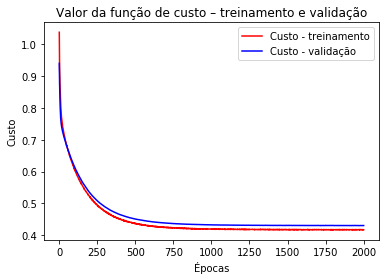

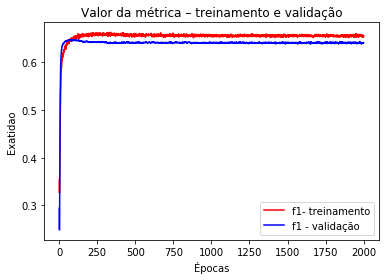

In [15]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [16]:
prob = np.ravel(model.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.4385429985902102, 0.4903211026688557, 0.5354852780806979, 0.5784850727855909, 0.6165221258616855, 0.6511728662499227, 0.6838383138043402, 0.7148507173322993, 0.7460414129110841, 0.7761326621261475, 0.8049385500056376, 0.829344028981757, 0.855640243902439, 0.8763470319634703, 0.9025462962962963, 0.9261146496815287, 0.9537275064267352, 0.9863201094391245]
recall values: [0.9460357875380154, 0.9082679114505976, 0.8682367918523234, 0.8291251149303346, 0.7843553292312044, 0.7441120305537874, 0.6975740858618007, 0.6519555838460994, 0.6064785345498267, 0.5561213664332697, 0.5049154820001415, 0.4533559657684419, 0.39698705707617227, 0.3393450739090459, 0.2757620765259212, 0.2056722540490841, 0.13119739726996252, 0.05099370535398543]
f1 values: [0.5992831541218638, 0.6368460203322589, 0.6624217569609324, 0.6814905243576329, 0.6903850343947459, 0.694547134935305, 0.6906379105104685, 0.681956055337723, 0.6690594155970819, 0.6479604449938196, 0.620566759388039, 0.5862447411743

Normalized confusion matrix
[[0.45482618 0.54517382]
 [0.05396421 0.94603579]]
Normalized confusion matrix
[[0.57503502 0.42496498]
 [0.09173209 0.90826791]]
Normalized confusion matrix
[[0.66098943 0.33901057]
 [0.13176321 0.86823679]]
Normalized confusion matrix
[[0.72806571 0.27193429]
 [0.17087489 0.82912511]]
Normalized confusion matrix
[[0.78040239 0.21959761]
 [0.21564467 0.78435533]]
Normalized confusion matrix
[[0.82057812 0.17942188]
 [0.25588797 0.74411203]]
Normalized confusion matrix
[[0.85483255 0.14516745]
 [0.30242591 0.69757409]]
Normalized confusion matrix
[[0.88294282 0.11705718]
 [0.34804442 0.65195558]]
Normalized confusion matrix
[[0.90707373 0.09292627]
 [0.39352147 0.60647853]]
Normalized confusion matrix
[[0.92779829 0.07220171]
 [0.44387863 0.55612137]]
Normalized confusion matrix
[[0.94492551 0.05507449]
 [0.49508452 0.50491548]]
Normalized confusion matrix
[[0.95800968 0.04199032]
 [0.54664403 0.45335597]]
Normalized confusion matrix
[[0.96985229 0.03014771]

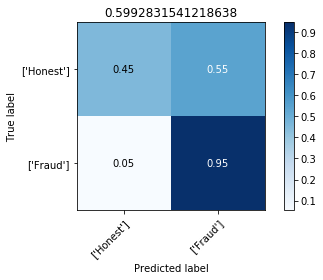

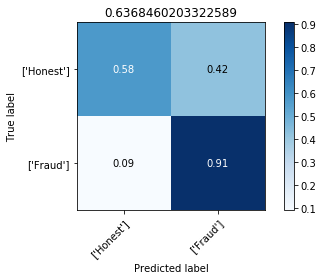

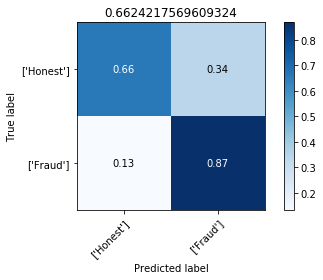

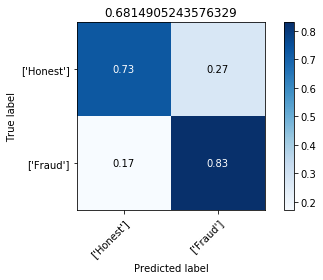

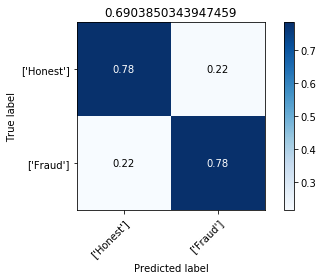

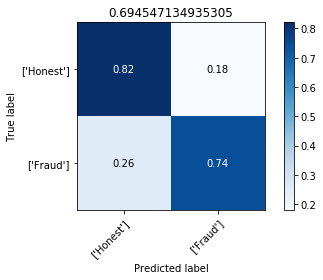

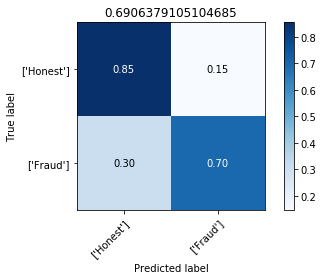

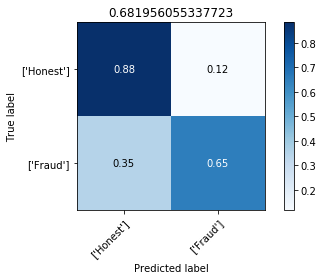

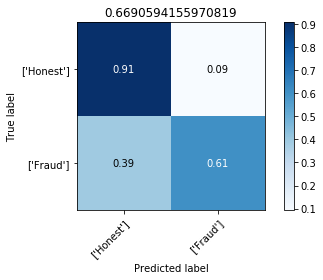

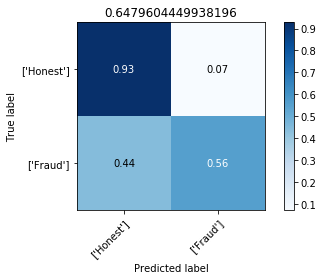

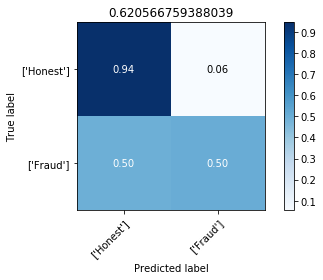

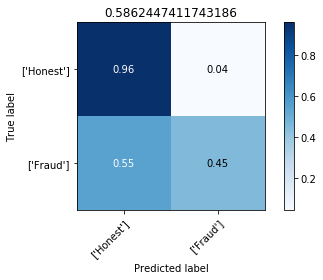

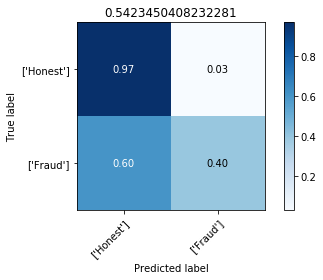

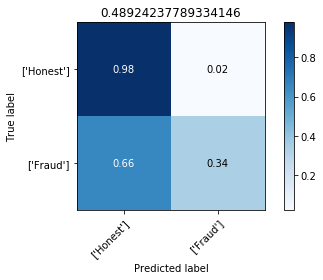

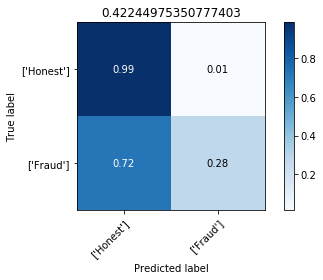

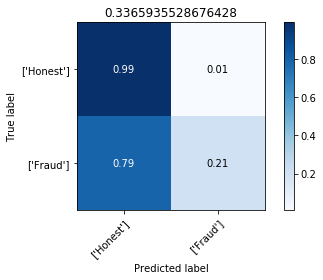

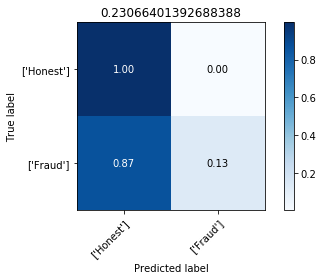

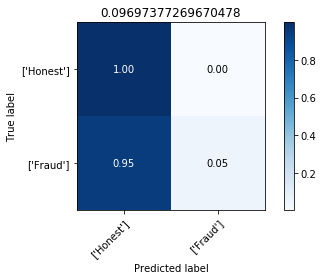

In [17]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [18]:
K.clear_session()

In [19]:
model1 = models.Sequential()
model1.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(units = 1,activation = 'sigmoid'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

In [20]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model1.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model1.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val))

Train on 45551 samples, validate on 9761 samples
Epoch 1/2000
45551/45551 [==============================] - 4s 79us/step - loss: 0.8928 - f1Score: 0.3903 - val_loss: 0.7879 - val_f1Score: 0.3820
Epoch 2/2000
45551/45551 [==============================] - 3s 73us/step - loss: 0.8122 - f1Score: 0.3779 - val_loss: 0.7457 - val_f1Score: 0.3738
Epoch 3/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.7817 - f1Score: 0.3879 - val_loss: 0.7209 - val_f1Score: 0.4108
Epoch 4/2000
45551/45551 [==============================] - 3s 75us/step - loss: 0.7606 - f1Score: 0.4110 - val_loss: 0.7010 - val_f1Score: 0.4669
Epoch 5/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.7415 - f1Score: 0.4474 - val_loss: 0.6841 - val_f1Score: 0.5209
Epoch 6/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.7219 - f1Score: 0.4846 - val_loss: 0.6704 - val_f1Score: 0.5548
Epoch 7/2000
45551/45551 [==============================] - 3s 74us/s

45551/45551 [==============================] - 5s 120us/step - loss: 0.5786 - f1Score: 0.6374 - val_loss: 0.5774 - val_f1Score: 0.6451
Epoch 57/2000
45551/45551 [==============================] - 4s 87us/step - loss: 0.5756 - f1Score: 0.6409 - val_loss: 0.5769 - val_f1Score: 0.6465
Epoch 58/2000
45551/45551 [==============================] - 3s 72us/step - loss: 0.5769 - f1Score: 0.6355 - val_loss: 0.5758 - val_f1Score: 0.6460
Epoch 59/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.5744 - f1Score: 0.6398 - val_loss: 0.5751 - val_f1Score: 0.6464
Epoch 60/2000
45551/45551 [==============================] - 4s 92us/step - loss: 0.5736 - f1Score: 0.6408 - val_loss: 0.5742 - val_f1Score: 0.6467
Epoch 61/2000
45551/45551 [==============================] - 4s 91us/step - loss: 0.5717 - f1Score: 0.6376 - val_loss: 0.5735 - val_f1Score: 0.6464
Epoch 62/2000
45551/45551 [==============================] - 4s 77us/step - loss: 0.5714 - f1Score: 0.6405 - val_loss: 0.5725

45551/45551 [==============================] - 4s 79us/step - loss: 0.4953 - f1Score: 0.6593 - val_loss: 0.5087 - val_f1Score: 0.6420
Epoch 167/2000
45551/45551 [==============================] - 3s 75us/step - loss: 0.4958 - f1Score: 0.6556 - val_loss: 0.5081 - val_f1Score: 0.6419
Epoch 168/2000
45551/45551 [==============================] - 4s 77us/step - loss: 0.4957 - f1Score: 0.6546 - val_loss: 0.5076 - val_f1Score: 0.6425
Epoch 169/2000
45551/45551 [==============================] - 4s 77us/step - loss: 0.4928 - f1Score: 0.6591 - val_loss: 0.5072 - val_f1Score: 0.6423
Epoch 170/2000
45551/45551 [==============================] - 3s 77us/step - loss: 0.4936 - f1Score: 0.6561 - val_loss: 0.5069 - val_f1Score: 0.6423
Epoch 171/2000
45551/45551 [==============================] - 4s 78us/step - loss: 0.4920 - f1Score: 0.6560 - val_loss: 0.5066 - val_f1Score: 0.6419
Epoch 172/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.4922 - f1Score: 0.6561 - val_loss: 0

45551/45551 [==============================] - 3s 69us/step - loss: 0.4711 - f1Score: 0.6629 - val_loss: 0.4876 - val_f1Score: 0.6421
Epoch 222/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4708 - f1Score: 0.6565 - val_loss: 0.4874 - val_f1Score: 0.6419
Epoch 223/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4688 - f1Score: 0.6638 - val_loss: 0.4873 - val_f1Score: 0.6416
Epoch 224/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4710 - f1Score: 0.6588 - val_loss: 0.4867 - val_f1Score: 0.6423
Epoch 225/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4701 - f1Score: 0.6598 - val_loss: 0.4865 - val_f1Score: 0.6417
Epoch 226/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4708 - f1Score: 0.6585 - val_loss: 0.4861 - val_f1Score: 0.6423
Epoch 227/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4693 - f1Score: 0.6600 - val_loss: 0

45551/45551 [==============================] - 3s 70us/step - loss: 0.4532 - f1Score: 0.6635 - val_loss: 0.4726 - val_f1Score: 0.6400
Epoch 277/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4524 - f1Score: 0.6640 - val_loss: 0.4726 - val_f1Score: 0.6405
Epoch 278/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4532 - f1Score: 0.6627 - val_loss: 0.4722 - val_f1Score: 0.6407
Epoch 279/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4514 - f1Score: 0.6671 - val_loss: 0.4721 - val_f1Score: 0.6411
Epoch 280/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4513 - f1Score: 0.6635 - val_loss: 0.4719 - val_f1Score: 0.6409
Epoch 281/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4514 - f1Score: 0.6657 - val_loss: 0.4717 - val_f1Score: 0.6408
Epoch 282/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4518 - f1Score: 0.6625 - val_loss: 0

45551/45551 [==============================] - 3s 69us/step - loss: 0.4407 - f1Score: 0.6635 - val_loss: 0.4621 - val_f1Score: 0.6418
Epoch 332/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4406 - f1Score: 0.6630 - val_loss: 0.4618 - val_f1Score: 0.6416
Epoch 333/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4403 - f1Score: 0.6673 - val_loss: 0.4616 - val_f1Score: 0.6412
Epoch 334/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4393 - f1Score: 0.6649 - val_loss: 0.4615 - val_f1Score: 0.6419
Epoch 335/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4387 - f1Score: 0.6673 - val_loss: 0.4614 - val_f1Score: 0.6418
Epoch 336/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4390 - f1Score: 0.6640 - val_loss: 0.4612 - val_f1Score: 0.6413
Epoch 337/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4400 - f1Score: 0.6643 - val_loss: 0

45551/45551 [==============================] - 3s 70us/step - loss: 0.4301 - f1Score: 0.6696 - val_loss: 0.4541 - val_f1Score: 0.6402
Epoch 387/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4294 - f1Score: 0.6680 - val_loss: 0.4541 - val_f1Score: 0.6398
Epoch 388/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4286 - f1Score: 0.6652 - val_loss: 0.4541 - val_f1Score: 0.6402
Epoch 389/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4301 - f1Score: 0.6691 - val_loss: 0.4537 - val_f1Score: 0.6393
Epoch 390/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4300 - f1Score: 0.6703 - val_loss: 0.4535 - val_f1Score: 0.6395
Epoch 391/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4287 - f1Score: 0.6690 - val_loss: 0.4535 - val_f1Score: 0.6396
Epoch 392/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4297 - f1Score: 0.6664 - val_loss: 0

45551/45551 [==============================] - 3s 70us/step - loss: 0.4224 - f1Score: 0.6713 - val_loss: 0.4485 - val_f1Score: 0.6406
Epoch 442/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4215 - f1Score: 0.6697 - val_loss: 0.4484 - val_f1Score: 0.6415
Epoch 443/2000
45551/45551 [==============================] - 3s 73us/step - loss: 0.4212 - f1Score: 0.6675 - val_loss: 0.4484 - val_f1Score: 0.6412
Epoch 444/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4211 - f1Score: 0.6707 - val_loss: 0.4483 - val_f1Score: 0.6405
Epoch 445/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4216 - f1Score: 0.6686 - val_loss: 0.4481 - val_f1Score: 0.6406
Epoch 446/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4203 - f1Score: 0.6726 - val_loss: 0.4481 - val_f1Score: 0.6404
Epoch 447/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4209 - f1Score: 0.6700 - val_loss: 0

45551/45551 [==============================] - 3s 71us/step - loss: 0.4145 - f1Score: 0.6720 - val_loss: 0.4447 - val_f1Score: 0.6394
Epoch 497/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4144 - f1Score: 0.6725 - val_loss: 0.4446 - val_f1Score: 0.6393
Epoch 498/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4145 - f1Score: 0.6717 - val_loss: 0.4447 - val_f1Score: 0.6398
Epoch 499/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4143 - f1Score: 0.6695 - val_loss: 0.4446 - val_f1Score: 0.6399
Epoch 500/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4147 - f1Score: 0.6742 - val_loss: 0.4444 - val_f1Score: 0.6389
Epoch 501/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4143 - f1Score: 0.6753 - val_loss: 0.4444 - val_f1Score: 0.6394
Epoch 502/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4137 - f1Score: 0.6741 - val_loss: 0

45551/45551 [==============================] - 3s 69us/step - loss: 0.4107 - f1Score: 0.6744 - val_loss: 0.4418 - val_f1Score: 0.6386
Epoch 552/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4101 - f1Score: 0.6742 - val_loss: 0.4418 - val_f1Score: 0.6390
Epoch 553/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4095 - f1Score: 0.6769 - val_loss: 0.4419 - val_f1Score: 0.6392
Epoch 554/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4095 - f1Score: 0.6766 - val_loss: 0.4418 - val_f1Score: 0.6388
Epoch 555/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4088 - f1Score: 0.6732 - val_loss: 0.4419 - val_f1Score: 0.6392
Epoch 556/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4101 - f1Score: 0.6754 - val_loss: 0.4416 - val_f1Score: 0.6394
Epoch 557/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4094 - f1Score: 0.6725 - val_loss: 0

45551/45551 [==============================] - 3s 69us/step - loss: 0.4055 - f1Score: 0.6751 - val_loss: 0.4399 - val_f1Score: 0.6373
Epoch 607/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4054 - f1Score: 0.6770 - val_loss: 0.4399 - val_f1Score: 0.6370
Epoch 608/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4064 - f1Score: 0.6771 - val_loss: 0.4399 - val_f1Score: 0.6375
Epoch 609/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4048 - f1Score: 0.6778 - val_loss: 0.4401 - val_f1Score: 0.6381
Epoch 610/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4053 - f1Score: 0.6784 - val_loss: 0.4401 - val_f1Score: 0.6379
Epoch 611/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4041 - f1Score: 0.6787 - val_loss: 0.4401 - val_f1Score: 0.6374
Epoch 612/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4039 - f1Score: 0.6780 - val_loss: 0

45551/45551 [==============================] - 3s 70us/step - loss: 0.4027 - f1Score: 0.6790 - val_loss: 0.4387 - val_f1Score: 0.6367
Epoch 662/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4009 - f1Score: 0.6793 - val_loss: 0.4387 - val_f1Score: 0.6354
Epoch 663/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4023 - f1Score: 0.6771 - val_loss: 0.4388 - val_f1Score: 0.6364
Epoch 664/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.4020 - f1Score: 0.6784 - val_loss: 0.4387 - val_f1Score: 0.6372
Epoch 665/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4011 - f1Score: 0.6826 - val_loss: 0.4386 - val_f1Score: 0.6375
Epoch 666/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4002 - f1Score: 0.6836 - val_loss: 0.4389 - val_f1Score: 0.6375
Epoch 667/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4000 - f1Score: 0.6825 - val_loss: 0

45551/45551 [==============================] - 3s 68us/step - loss: 0.3982 - f1Score: 0.6825 - val_loss: 0.4384 - val_f1Score: 0.6363
Epoch 717/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3963 - f1Score: 0.6826 - val_loss: 0.4386 - val_f1Score: 0.6365
Epoch 718/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3959 - f1Score: 0.6824 - val_loss: 0.4387 - val_f1Score: 0.6373
Epoch 719/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3966 - f1Score: 0.6829 - val_loss: 0.4386 - val_f1Score: 0.6371
Epoch 720/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3964 - f1Score: 0.6830 - val_loss: 0.4387 - val_f1Score: 0.6382
Epoch 721/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3969 - f1Score: 0.6811 - val_loss: 0.4386 - val_f1Score: 0.6396
Epoch 722/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3992 - f1Score: 0.6806 - val_loss: 0

45551/45551 [==============================] - 3s 69us/step - loss: 0.3949 - f1Score: 0.6831 - val_loss: 0.4381 - val_f1Score: 0.6399
Epoch 772/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3948 - f1Score: 0.6834 - val_loss: 0.4380 - val_f1Score: 0.6386
Epoch 773/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3953 - f1Score: 0.6833 - val_loss: 0.4378 - val_f1Score: 0.6398
Epoch 774/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3950 - f1Score: 0.6850 - val_loss: 0.4378 - val_f1Score: 0.6385
Epoch 775/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3953 - f1Score: 0.6798 - val_loss: 0.4380 - val_f1Score: 0.6388
Epoch 776/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3945 - f1Score: 0.6836 - val_loss: 0.4380 - val_f1Score: 0.6394
Epoch 777/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3937 - f1Score: 0.6878 - val_loss: 0

45551/45551 [==============================] - 3s 69us/step - loss: 0.3910 - f1Score: 0.6853 - val_loss: 0.4381 - val_f1Score: 0.6389
Epoch 827/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3915 - f1Score: 0.6868 - val_loss: 0.4380 - val_f1Score: 0.6381
Epoch 828/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3895 - f1Score: 0.6902 - val_loss: 0.4383 - val_f1Score: 0.6380
Epoch 829/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3904 - f1Score: 0.6897 - val_loss: 0.4383 - val_f1Score: 0.6386
Epoch 830/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3912 - f1Score: 0.6870 - val_loss: 0.4383 - val_f1Score: 0.6387
Epoch 831/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3906 - f1Score: 0.6874 - val_loss: 0.4383 - val_f1Score: 0.6396
Epoch 832/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3911 - f1Score: 0.6842 - val_loss: 0

45551/45551 [==============================] - 3s 69us/step - loss: 0.3882 - f1Score: 0.6919 - val_loss: 0.4384 - val_f1Score: 0.6380
Epoch 882/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3867 - f1Score: 0.6895 - val_loss: 0.4386 - val_f1Score: 0.6385
Epoch 883/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3869 - f1Score: 0.6908 - val_loss: 0.4385 - val_f1Score: 0.6368
Epoch 884/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3882 - f1Score: 0.6903 - val_loss: 0.4382 - val_f1Score: 0.6375
Epoch 885/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3866 - f1Score: 0.6956 - val_loss: 0.4384 - val_f1Score: 0.6376
Epoch 886/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3863 - f1Score: 0.6926 - val_loss: 0.4386 - val_f1Score: 0.6388
Epoch 887/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3872 - f1Score: 0.6918 - val_loss: 0

45551/45551 [==============================] - 3s 68us/step - loss: 0.3867 - f1Score: 0.6923 - val_loss: 0.4388 - val_f1Score: 0.6361
Epoch 937/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.3863 - f1Score: 0.6922 - val_loss: 0.4387 - val_f1Score: 0.6373
Epoch 938/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3846 - f1Score: 0.6959 - val_loss: 0.4389 - val_f1Score: 0.6392
Epoch 939/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3858 - f1Score: 0.6899 - val_loss: 0.4386 - val_f1Score: 0.6380
Epoch 940/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3840 - f1Score: 0.6932 - val_loss: 0.4390 - val_f1Score: 0.6380
Epoch 941/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3837 - f1Score: 0.6950 - val_loss: 0.4391 - val_f1Score: 0.6386
Epoch 942/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3829 - f1Score: 0.6951 - val_loss: 0

45551/45551 [==============================] - 3s 69us/step - loss: 0.3814 - f1Score: 0.7011 - val_loss: 0.4398 - val_f1Score: 0.6369
Epoch 992/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.3816 - f1Score: 0.6958 - val_loss: 0.4396 - val_f1Score: 0.6381
Epoch 993/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3817 - f1Score: 0.6958 - val_loss: 0.4397 - val_f1Score: 0.6381
Epoch 994/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3817 - f1Score: 0.6968 - val_loss: 0.4397 - val_f1Score: 0.6387
Epoch 995/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3798 - f1Score: 0.6990 - val_loss: 0.4398 - val_f1Score: 0.6388
Epoch 996/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3805 - f1Score: 0.6994 - val_loss: 0.4397 - val_f1Score: 0.6371
Epoch 997/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3802 - f1Score: 0.6985 - val_loss: 0

Epoch 1046/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3766 - f1Score: 0.6982 - val_loss: 0.4408 - val_f1Score: 0.6384
Epoch 1047/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3797 - f1Score: 0.7034 - val_loss: 0.4403 - val_f1Score: 0.6368
Epoch 1048/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3782 - f1Score: 0.6987 - val_loss: 0.4403 - val_f1Score: 0.6384
Epoch 1049/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3802 - f1Score: 0.6974 - val_loss: 0.4402 - val_f1Score: 0.6385
Epoch 1050/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3779 - f1Score: 0.7002 - val_loss: 0.4404 - val_f1Score: 0.6391
Epoch 1051/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3785 - f1Score: 0.7016 - val_loss: 0.4403 - val_f1Score: 0.6387
Epoch 1052/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3801 - f1Score

Epoch 1155/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3725 - f1Score: 0.7078 - val_loss: 0.4424 - val_f1Score: 0.6377
Epoch 1156/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3742 - f1Score: 0.7025 - val_loss: 0.4420 - val_f1Score: 0.6364
Epoch 1157/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3723 - f1Score: 0.7055 - val_loss: 0.4419 - val_f1Score: 0.6378
Epoch 1158/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3707 - f1Score: 0.7066 - val_loss: 0.4425 - val_f1Score: 0.6397
Epoch 1159/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3718 - f1Score: 0.7047 - val_loss: 0.4425 - val_f1Score: 0.6380
Epoch 1160/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3710 - f1Score: 0.7100 - val_loss: 0.4425 - val_f1Score: 0.6388
Epoch 1161/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3715 - f1Score

Epoch 1264/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3675 - f1Score: 0.7118 - val_loss: 0.4441 - val_f1Score: 0.6389
Epoch 1265/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3664 - f1Score: 0.7104 - val_loss: 0.4446 - val_f1Score: 0.6392
Epoch 1266/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3632 - f1Score: 0.7161 - val_loss: 0.4449 - val_f1Score: 0.6390
Epoch 1267/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3674 - f1Score: 0.7112 - val_loss: 0.4444 - val_f1Score: 0.6376
Epoch 1268/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3657 - f1Score: 0.7136 - val_loss: 0.4447 - val_f1Score: 0.6386
Epoch 1269/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3642 - f1Score: 0.7139 - val_loss: 0.4450 - val_f1Score: 0.6374
Epoch 1270/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3644 - f1Score

Epoch 1373/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3591 - f1Score: 0.7219 - val_loss: 0.4475 - val_f1Score: 0.6366
Epoch 1374/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3588 - f1Score: 0.7184 - val_loss: 0.4468 - val_f1Score: 0.6363
Epoch 1375/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3594 - f1Score: 0.7174 - val_loss: 0.4470 - val_f1Score: 0.6386
Epoch 1376/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3586 - f1Score: 0.7214 - val_loss: 0.4471 - val_f1Score: 0.6384
Epoch 1377/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3605 - f1Score: 0.7182 - val_loss: 0.4471 - val_f1Score: 0.6394
Epoch 1378/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3617 - f1Score: 0.7168 - val_loss: 0.4466 - val_f1Score: 0.6386
Epoch 1379/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3593 - f1Score

Epoch 1482/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3519 - f1Score: 0.7240 - val_loss: 0.4499 - val_f1Score: 0.6334
Epoch 1483/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3534 - f1Score: 0.7281 - val_loss: 0.4496 - val_f1Score: 0.6360
Epoch 1484/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3528 - f1Score: 0.7260 - val_loss: 0.4499 - val_f1Score: 0.6353
Epoch 1485/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3521 - f1Score: 0.7244 - val_loss: 0.4499 - val_f1Score: 0.6348
Epoch 1486/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3530 - f1Score: 0.7252 - val_loss: 0.4495 - val_f1Score: 0.6363
Epoch 1487/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3540 - f1Score: 0.7274 - val_loss: 0.4496 - val_f1Score: 0.6358
Epoch 1488/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3533 - f1Score

Epoch 1591/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3485 - f1Score: 0.7317 - val_loss: 0.4521 - val_f1Score: 0.6364
Epoch 1592/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3468 - f1Score: 0.7328 - val_loss: 0.4524 - val_f1Score: 0.6362
Epoch 1593/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3480 - f1Score: 0.7314 - val_loss: 0.4521 - val_f1Score: 0.6349
Epoch 1594/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3464 - f1Score: 0.7291 - val_loss: 0.4522 - val_f1Score: 0.6337
Epoch 1595/2000
45551/45551 [==============================] - 3s 68us/step - loss: 0.3481 - f1Score: 0.7296 - val_loss: 0.4519 - val_f1Score: 0.6345
Epoch 1596/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3470 - f1Score: 0.7312 - val_loss: 0.4524 - val_f1Score: 0.6324
Epoch 1597/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.3465 - f1Score

Epoch 1700/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.3427 - f1Score: 0.7370 - val_loss: 0.4551 - val_f1Score: 0.6366
Epoch 1701/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.3427 - f1Score: 0.7365 - val_loss: 0.4551 - val_f1Score: 0.6378
Epoch 1702/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.3391 - f1Score: 0.7392 - val_loss: 0.4560 - val_f1Score: 0.6333
Epoch 1703/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.3419 - f1Score: 0.7376 - val_loss: 0.4553 - val_f1Score: 0.6320
Epoch 1704/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.3411 - f1Score: 0.7332 - val_loss: 0.4556 - val_f1Score: 0.6353
Epoch 1705/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.3425 - f1Score: 0.7383 - val_loss: 0.4549 - val_f1Score: 0.6343
Epoch 1706/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.3437 - f1Score

45551/45551 [==============================] - 6s 125us/step - loss: 0.3361 - f1Score: 0.7423 - val_loss: 0.4589 - val_f1Score: 0.6327
Epoch 1809/2000
45551/45551 [==============================] - 6s 131us/step - loss: 0.3373 - f1Score: 0.7422 - val_loss: 0.4585 - val_f1Score: 0.6344
Epoch 1810/2000
45551/45551 [==============================] - 5s 103us/step - loss: 0.3345 - f1Score: 0.7393 - val_loss: 0.4588 - val_f1Score: 0.6349
Epoch 1811/2000
45551/45551 [==============================] - 4s 91us/step - loss: 0.3370 - f1Score: 0.7433 - val_loss: 0.4580 - val_f1Score: 0.6310
Epoch 1812/2000
45551/45551 [==============================] - 4s 79us/step - loss: 0.3364 - f1Score: 0.7419 - val_loss: 0.4580 - val_f1Score: 0.6335
Epoch 1813/2000
45551/45551 [==============================] - 3s 77us/step - loss: 0.3361 - f1Score: 0.7418 - val_loss: 0.4577 - val_f1Score: 0.6329
Epoch 1814/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.3372 - f1Score: 0.7427 - va

Epoch 1917/2000
45551/45551 [==============================] - 3s 74us/step - loss: 0.3307 - f1Score: 0.7475 - val_loss: 0.4621 - val_f1Score: 0.6311
Epoch 1918/2000
45551/45551 [==============================] - 5s 101us/step - loss: 0.3313 - f1Score: 0.7459 - val_loss: 0.4621 - val_f1Score: 0.6346
Epoch 1919/2000
45551/45551 [==============================] - 3s 57us/step - loss: 0.3306 - f1Score: 0.7449 - val_loss: 0.4614 - val_f1Score: 0.6330
Epoch 1920/2000
45551/45551 [==============================] - 3s 55us/step - loss: 0.3319 - f1Score: 0.7421 - val_loss: 0.4612 - val_f1Score: 0.6340
Epoch 1921/2000
45551/45551 [==============================] - 3s 62us/step - loss: 0.3288 - f1Score: 0.7490 - val_loss: 0.4621 - val_f1Score: 0.6333
Epoch 1922/2000
45551/45551 [==============================] - 4s 88us/step - loss: 0.3292 - f1Score: 0.7495 - val_loss: 0.4621 - val_f1Score: 0.6333
Epoch 1923/2000
45551/45551 [==============================] - 3s 61us/step - loss: 0.3314 - f1Scor

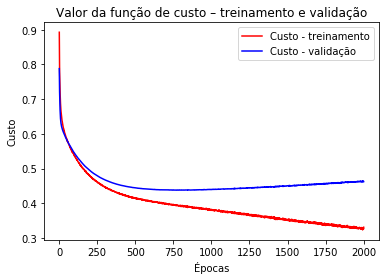

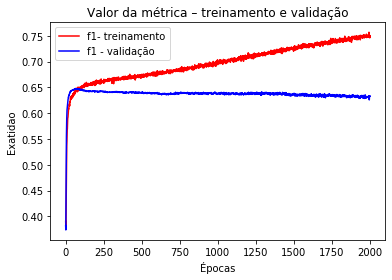

In [21]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [22]:
prob = np.ravel(model1.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.538010560646063, 0.607385247365601, 0.6666499924966235, 0.7185549356460256, 0.760340486752188, 0.797531342897764, 0.8309770875409151, 0.8577961019490254, 0.8840872374798061, 0.9032117297957759, 0.9201904761904762, 0.9351097178683385, 0.9493361285814116, 0.9616919393455706, 0.9714554579673776, 0.9824253075571178, 0.9883310719131615, 0.9959919839679359]
recall values: [0.9800551665605771, 0.9620906711931537, 0.9425701959120164, 0.9200084871631657, 0.8970931466157437, 0.8728340052337507, 0.8439069241106161, 0.8093217342103401, 0.7741000070726359, 0.7319470966829338, 0.6833580875592333, 0.6329301930829621, 0.5764905580309782, 0.5113515807341397, 0.43807907207016056, 0.35582431572246975, 0.257585402079355, 0.14060400311195984]
f1 values: [0.6946735179847097, 0.744655809497742, 0.7809551714034574, 0.8068978351218907, 0.8230751760163526, 0.8334852936210448, 0.837392097691066, 0.8328541795552967, 0.8254459067083977, 0.8086103840293786, 0.7842850765047282, 0.754903201315956

Normalized confusion matrix
[[0.62119572 0.37880428]
 [0.01994483 0.98005517]]
Normalized confusion matrix
[[0.72007513 0.27992487]
 [0.03790933 0.96209067]]
Normalized confusion matrix
[[0.78785178 0.21214822]
 [0.0574298  0.9425702 ]]
Normalized confusion matrix
[[0.83780084 0.16219916]
 [0.07999151 0.92000849]]
Normalized confusion matrix
[[0.8727238  0.1272762 ]
 [0.10290685 0.89709315]]
Normalized confusion matrix
[[0.90026105 0.09973895]
 [0.12716599 0.87283401]]
Normalized confusion matrix
[[0.92273653 0.07726347]
 [0.15609308 0.84390692]]
Normalized confusion matrix
[[0.93960907 0.06039093]
 [0.19067827 0.80932173]]
Normalized confusion matrix
[[0.95431682 0.04568318]
 [0.22589999 0.77410001]]
Normalized confusion matrix
[[0.96469502 0.03530498]
 [0.2680529  0.7319471 ]]
Normalized confusion matrix
[[0.9733223  0.0266777 ]
 [0.31664191 0.68335809]]
Normalized confusion matrix
[[0.98023049 0.01976951]
 [0.36706981 0.63293019]]
Normalized confusion matrix
[[0.98615179 0.01384821]

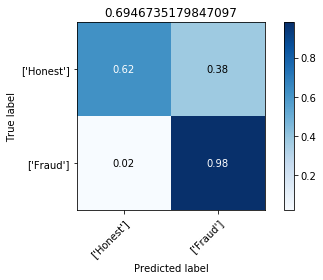

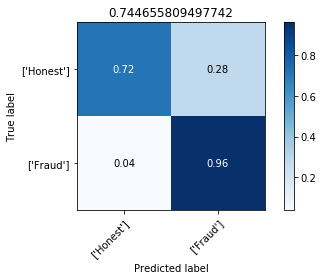

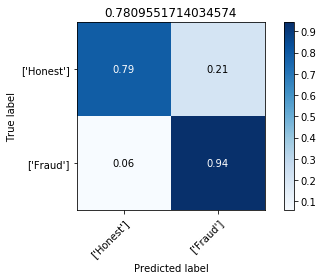

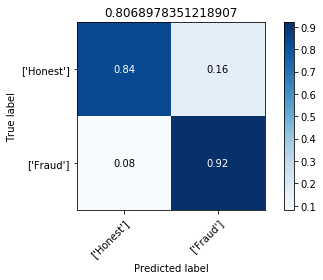

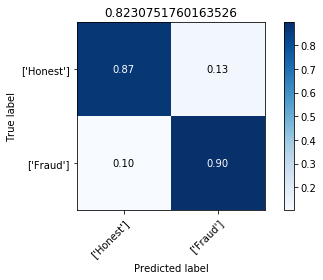

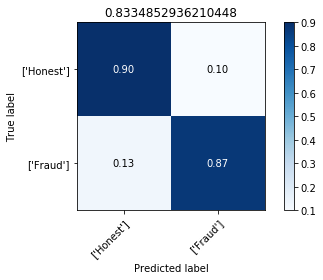

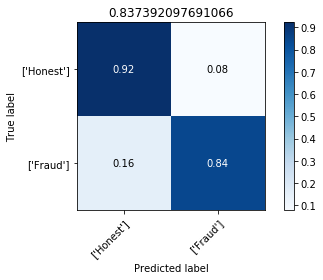

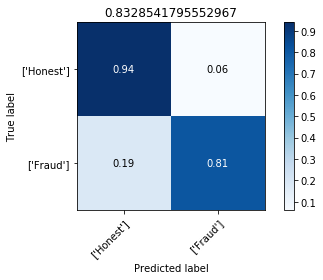

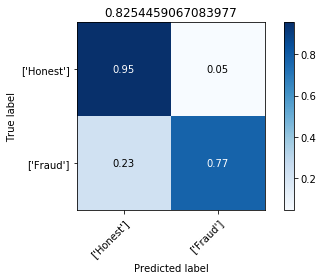

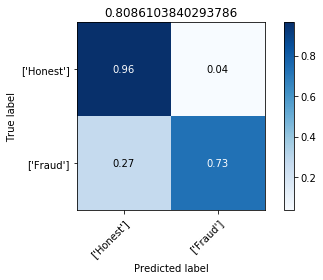

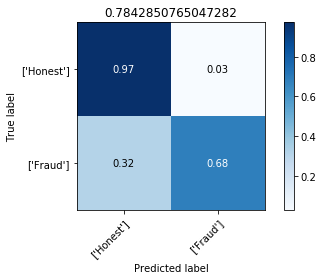

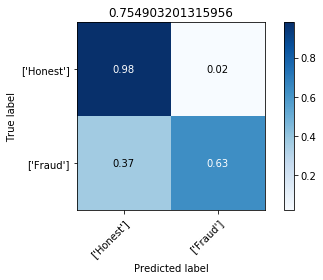

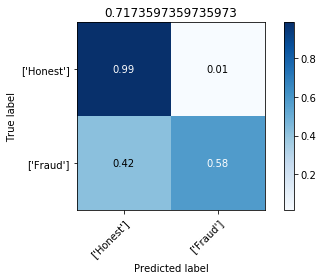

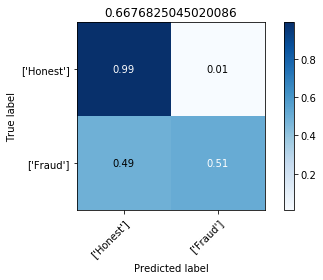

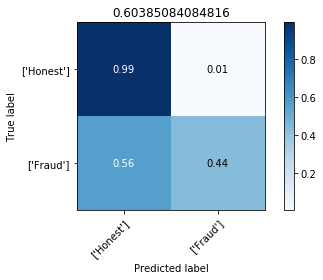

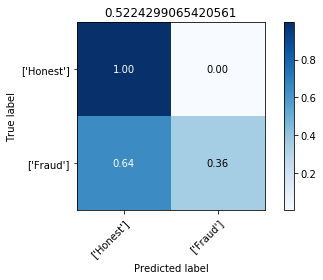

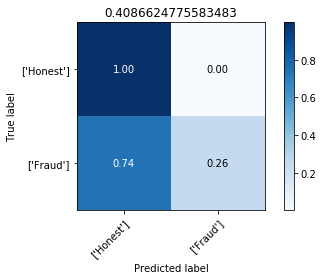

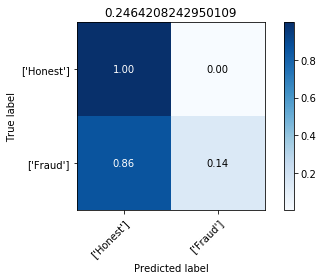

In [23]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [11]:
K.clear_session()

In [12]:
model2 = models.Sequential()
model2.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
BatchNormalization(axis=1)
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(units = 1,activation = 'sigmoid'))
model2.summary()

W1001 22:32:55.465843 139896072668992 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1001 22:32:55.471549 139896072668992 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1001 22:32:55.509199 139896072668992 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

In [13]:
mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
model2.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model2.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val))

W1001 22:32:55.748411 139896072668992 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1001 22:32:55.764343 139896072668992 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 45551 samples, validate on 9761 samples
Epoch 1/2000
45551/45551 [==============================] - 6s 134us/step - loss: 1.8660 - f1Score: 0.3679 - val_loss: 1.8176 - val_f1Score: 0.3436
Epoch 2/2000
45551/45551 [==============================] - 4s 89us/step - loss: 1.8426 - f1Score: 0.3606 - val_loss: 1.7920 - val_f1Score: 0.3336
Epoch 3/2000
45551/45551 [==============================] - 4s 86us/step - loss: 1.8179 - f1Score: 0.3546 - val_loss: 1.7697 - val_f1Score: 0.3267
Epoch 4/2000
45551/45551 [==============================] - 4s 87us/step - loss: 1.7987 - f1Score: 0.3503 - val_loss: 1.7500 - val_f1Score: 0.3181
Epoch 5/2000
45551/45551 [==============================] - 4s 88us/step - loss: 1.7794 - f1Score: 0.3490 - val_loss: 1.7323 - val_f1Score: 0.3100
Epoch 6/2000
45551/45551 [==============================] - 4s 87us/step - loss: 1.7603 - f1Score: 0.3442 - val_loss: 1.7163 - val_f1Score: 0.2993
Epoch 7/2000
45551/45551 [==============================] - 4s 87us/

45551/45551 [==============================] - 4s 90us/step - loss: 1.3758 - f1Score: 0.4124 - val_loss: 1.3349 - val_f1Score: 0.4398
Epoch 57/2000
45551/45551 [==============================] - 4s 87us/step - loss: 1.3695 - f1Score: 0.4231 - val_loss: 1.3292 - val_f1Score: 0.4445
Epoch 58/2000
45551/45551 [==============================] - 4s 79us/step - loss: 1.3653 - f1Score: 0.4168 - val_loss: 1.3235 - val_f1Score: 0.4499
Epoch 59/2000
45551/45551 [==============================] - 4s 82us/step - loss: 1.3595 - f1Score: 0.4221 - val_loss: 1.3178 - val_f1Score: 0.4532
Epoch 60/2000
45551/45551 [==============================] - 4s 81us/step - loss: 1.3529 - f1Score: 0.4336 - val_loss: 1.3122 - val_f1Score: 0.4610
Epoch 61/2000
45551/45551 [==============================] - 4s 85us/step - loss: 1.3485 - f1Score: 0.4310 - val_loss: 1.3067 - val_f1Score: 0.4668
Epoch 62/2000
45551/45551 [==============================] - 4s 81us/step - loss: 1.3404 - f1Score: 0.4418 - val_loss: 1.3011 

45551/45551 [==============================] - 3s 76us/step - loss: 1.1199 - f1Score: 0.5487 - val_loss: 1.0821 - val_f1Score: 0.5938
Epoch 112/2000
45551/45551 [==============================] - 3s 76us/step - loss: 1.1110 - f1Score: 0.5562 - val_loss: 1.0785 - val_f1Score: 0.5952
Epoch 113/2000
45551/45551 [==============================] - 3s 76us/step - loss: 1.1063 - f1Score: 0.5594 - val_loss: 1.0750 - val_f1Score: 0.5954
Epoch 114/2000
45551/45551 [==============================] - 3s 76us/step - loss: 1.1054 - f1Score: 0.5545 - val_loss: 1.0715 - val_f1Score: 0.5962
Epoch 115/2000
45551/45551 [==============================] - 4s 78us/step - loss: 1.1014 - f1Score: 0.5571 - val_loss: 1.0680 - val_f1Score: 0.5966
Epoch 116/2000
45551/45551 [==============================] - 3s 76us/step - loss: 1.0989 - f1Score: 0.5612 - val_loss: 1.0646 - val_f1Score: 0.5968
Epoch 117/2000
45551/45551 [==============================] - 4s 78us/step - loss: 1.0927 - f1Score: 0.5586 - val_loss: 1

Epoch 166/2000
45551/45551 [==============================] - 4s 81us/step - loss: 0.9460 - f1Score: 0.5943 - val_loss: 0.9207 - val_f1Score: 0.6172
Epoch 167/2000
45551/45551 [==============================] - 4s 97us/step - loss: 0.9429 - f1Score: 0.5894 - val_loss: 0.9183 - val_f1Score: 0.6171
Epoch 168/2000
45551/45551 [==============================] - 4s 86us/step - loss: 0.9397 - f1Score: 0.5909 - val_loss: 0.9159 - val_f1Score: 0.6179
Epoch 169/2000
45551/45551 [==============================] - 4s 87us/step - loss: 0.9388 - f1Score: 0.5949 - val_loss: 0.9135 - val_f1Score: 0.6179
Epoch 170/2000
45551/45551 [==============================] - 4s 94us/step - loss: 0.9352 - f1Score: 0.5915 - val_loss: 0.9112 - val_f1Score: 0.6172
Epoch 171/2000
45551/45551 [==============================] - 4s 93us/step - loss: 0.9313 - f1Score: 0.5962 - val_loss: 0.9089 - val_f1Score: 0.6176
Epoch 172/2000
45551/45551 [==============================] - 4s 78us/step - loss: 0.9315 - f1Score: 0.593

Epoch 221/2000
45551/45551 [==============================] - 4s 81us/step - loss: 0.8253 - f1Score: 0.6045 - val_loss: 0.8084 - val_f1Score: 0.6251
Epoch 222/2000
45551/45551 [==============================] - 3s 77us/step - loss: 0.8246 - f1Score: 0.6042 - val_loss: 0.8067 - val_f1Score: 0.6245
Epoch 223/2000
45551/45551 [==============================] - 3s 77us/step - loss: 0.8220 - f1Score: 0.6099 - val_loss: 0.8049 - val_f1Score: 0.6252
Epoch 224/2000
45551/45551 [==============================] - 3s 77us/step - loss: 0.8198 - f1Score: 0.6083 - val_loss: 0.8033 - val_f1Score: 0.6253
Epoch 225/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.8178 - f1Score: 0.6147 - val_loss: 0.8016 - val_f1Score: 0.6249
Epoch 226/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.8162 - f1Score: 0.6108 - val_loss: 0.7999 - val_f1Score: 0.6249
Epoch 227/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.8148 - f1Score: 0.610

Epoch 276/2000
45551/45551 [==============================] - 4s 86us/step - loss: 0.7402 - f1Score: 0.6147 - val_loss: 0.7274 - val_f1Score: 0.6294
Epoch 277/2000
45551/45551 [==============================] - 4s 93us/step - loss: 0.7375 - f1Score: 0.6152 - val_loss: 0.7261 - val_f1Score: 0.6290
Epoch 278/2000
45551/45551 [==============================] - 4s 83us/step - loss: 0.7384 - f1Score: 0.6113 - val_loss: 0.7249 - val_f1Score: 0.6297
Epoch 279/2000
45551/45551 [==============================] - 4s 90us/step - loss: 0.7334 - f1Score: 0.6197 - val_loss: 0.7237 - val_f1Score: 0.6297
Epoch 280/2000
45551/45551 [==============================] - 4s 87us/step - loss: 0.7349 - f1Score: 0.6192 - val_loss: 0.7224 - val_f1Score: 0.6295
Epoch 281/2000
45551/45551 [==============================] - 5s 102us/step - loss: 0.7317 - f1Score: 0.6195 - val_loss: 0.7212 - val_f1Score: 0.6297
Epoch 282/2000
45551/45551 [==============================] - 4s 92us/step - loss: 0.7309 - f1Score: 0.61

Epoch 331/2000
45551/45551 [==============================] - 4s 88us/step - loss: 0.6777 - f1Score: 0.6224 - val_loss: 0.6682 - val_f1Score: 0.6309
Epoch 332/2000
45551/45551 [==============================] - 4s 90us/step - loss: 0.6766 - f1Score: 0.6195 - val_loss: 0.6673 - val_f1Score: 0.6304
Epoch 333/2000
45551/45551 [==============================] - 4s 96us/step - loss: 0.6725 - f1Score: 0.6300 - val_loss: 0.6664 - val_f1Score: 0.6303
Epoch 334/2000
45551/45551 [==============================] - 4s 80us/step - loss: 0.6737 - f1Score: 0.6243 - val_loss: 0.6654 - val_f1Score: 0.6309
Epoch 335/2000
45551/45551 [==============================] - 4s 77us/step - loss: 0.6720 - f1Score: 0.6228 - val_loss: 0.6646 - val_f1Score: 0.6312
Epoch 336/2000
45551/45551 [==============================] - 4s 80us/step - loss: 0.6705 - f1Score: 0.6293 - val_loss: 0.6637 - val_f1Score: 0.6311
Epoch 337/2000
45551/45551 [==============================] - 4s 80us/step - loss: 0.6734 - f1Score: 0.618

Epoch 386/2000
45551/45551 [==============================] - 4s 88us/step - loss: 0.6303 - f1Score: 0.6334 - val_loss: 0.6246 - val_f1Score: 0.6336
Epoch 387/2000
45551/45551 [==============================] - 4s 94us/step - loss: 0.6290 - f1Score: 0.6285 - val_loss: 0.6239 - val_f1Score: 0.6338
Epoch 388/2000
45551/45551 [==============================] - 4s 92us/step - loss: 0.6291 - f1Score: 0.6259 - val_loss: 0.6232 - val_f1Score: 0.6333
Epoch 389/2000
45551/45551 [==============================] - 4s 88us/step - loss: 0.6274 - f1Score: 0.6304 - val_loss: 0.6226 - val_f1Score: 0.6333
Epoch 390/2000
45551/45551 [==============================] - 5s 102us/step - loss: 0.6260 - f1Score: 0.6322 - val_loss: 0.6219 - val_f1Score: 0.6335
Epoch 391/2000
45551/45551 [==============================] - 5s 115us/step - loss: 0.6254 - f1Score: 0.6289 - val_loss: 0.6213 - val_f1Score: 0.6334
Epoch 392/2000
45551/45551 [==============================] - 4s 91us/step - loss: 0.6266 - f1Score: 0.6

Epoch 441/2000
45551/45551 [==============================] - 4s 86us/step - loss: 0.5972 - f1Score: 0.6310 - val_loss: 0.5923 - val_f1Score: 0.6341
Epoch 442/2000
45551/45551 [==============================] - 4s 84us/step - loss: 0.5960 - f1Score: 0.6288 - val_loss: 0.5918 - val_f1Score: 0.6343
Epoch 443/2000
45551/45551 [==============================] - 4s 90us/step - loss: 0.5936 - f1Score: 0.6351 - val_loss: 0.5913 - val_f1Score: 0.6340
Epoch 444/2000
45551/45551 [==============================] - 4s 88us/step - loss: 0.5936 - f1Score: 0.6279 - val_loss: 0.5908 - val_f1Score: 0.6340
Epoch 445/2000
45551/45551 [==============================] - 4s 96us/step - loss: 0.5937 - f1Score: 0.6296 - val_loss: 0.5903 - val_f1Score: 0.6341
Epoch 446/2000
45551/45551 [==============================] - 4s 85us/step - loss: 0.5922 - f1Score: 0.6295 - val_loss: 0.5898 - val_f1Score: 0.6342
Epoch 447/2000
45551/45551 [==============================] - 4s 88us/step - loss: 0.5942 - f1Score: 0.630

Epoch 496/2000
45551/45551 [==============================] - 4s 97us/step - loss: 0.5701 - f1Score: 0.6338 - val_loss: 0.5682 - val_f1Score: 0.6348
Epoch 497/2000
45551/45551 [==============================] - 4s 91us/step - loss: 0.5692 - f1Score: 0.6359 - val_loss: 0.5678 - val_f1Score: 0.6348
Epoch 498/2000
45551/45551 [==============================] - 4s 89us/step - loss: 0.5691 - f1Score: 0.6317 - val_loss: 0.5674 - val_f1Score: 0.6348
Epoch 499/2000
45551/45551 [==============================] - 4s 79us/step - loss: 0.5690 - f1Score: 0.6372 - val_loss: 0.5670 - val_f1Score: 0.6348
Epoch 500/2000
45551/45551 [==============================] - 4s 89us/step - loss: 0.5683 - f1Score: 0.6308 - val_loss: 0.5666 - val_f1Score: 0.6352
Epoch 501/2000
45551/45551 [==============================] - 4s 84us/step - loss: 0.5677 - f1Score: 0.6358 - val_loss: 0.5663 - val_f1Score: 0.6353
Epoch 502/2000
45551/45551 [==============================] - 4s 82us/step - loss: 0.5647 - f1Score: 0.638

Epoch 551/2000
45551/45551 [==============================] - 5s 111us/step - loss: 0.5505 - f1Score: 0.6330 - val_loss: 0.5500 - val_f1Score: 0.6351
Epoch 552/2000
45551/45551 [==============================] - 4s 92us/step - loss: 0.5500 - f1Score: 0.6379 - val_loss: 0.5497 - val_f1Score: 0.6351
Epoch 553/2000
45551/45551 [==============================] - 4s 88us/step - loss: 0.5481 - f1Score: 0.6401 - val_loss: 0.5494 - val_f1Score: 0.6351
Epoch 554/2000
45551/45551 [==============================] - 4s 89us/step - loss: 0.5475 - f1Score: 0.6394 - val_loss: 0.5492 - val_f1Score: 0.6348
Epoch 555/2000
45551/45551 [==============================] - 4s 88us/step - loss: 0.5495 - f1Score: 0.6381 - val_loss: 0.5489 - val_f1Score: 0.6350
Epoch 556/2000
45551/45551 [==============================] - 4s 91us/step - loss: 0.5480 - f1Score: 0.6392 - val_loss: 0.5486 - val_f1Score: 0.6349
Epoch 557/2000
45551/45551 [==============================] - 4s 88us/step - loss: 0.5489 - f1Score: 0.63

Epoch 606/2000
45551/45551 [==============================] - 4s 86us/step - loss: 0.5358 - f1Score: 0.6395 - val_loss: 0.5362 - val_f1Score: 0.6367
Epoch 607/2000
45551/45551 [==============================] - 4s 86us/step - loss: 0.5354 - f1Score: 0.6355 - val_loss: 0.5360 - val_f1Score: 0.6365
Epoch 608/2000
45551/45551 [==============================] - 4s 87us/step - loss: 0.5348 - f1Score: 0.6414 - val_loss: 0.5358 - val_f1Score: 0.6367
Epoch 609/2000
45551/45551 [==============================] - 4s 96us/step - loss: 0.5328 - f1Score: 0.6398 - val_loss: 0.5356 - val_f1Score: 0.6367
Epoch 610/2000
45551/45551 [==============================] - 4s 90us/step - loss: 0.5332 - f1Score: 0.6376 - val_loss: 0.5354 - val_f1Score: 0.6369
Epoch 611/2000
45551/45551 [==============================] - 4s 93us/step - loss: 0.5335 - f1Score: 0.6389 - val_loss: 0.5351 - val_f1Score: 0.6369
Epoch 612/2000
45551/45551 [==============================] - 4s 93us/step - loss: 0.5337 - f1Score: 0.639

Epoch 661/2000
45551/45551 [==============================] - 6s 124us/step - loss: 0.5233 - f1Score: 0.6413 - val_loss: 0.5256 - val_f1Score: 0.6374
Epoch 662/2000
45551/45551 [==============================] - 6s 126us/step - loss: 0.5240 - f1Score: 0.6371 - val_loss: 0.5254 - val_f1Score: 0.6376
Epoch 663/2000
45551/45551 [==============================] - 6s 122us/step - loss: 0.5220 - f1Score: 0.6416 - val_loss: 0.5253 - val_f1Score: 0.6376
Epoch 664/2000
45551/45551 [==============================] - 5s 117us/step - loss: 0.5232 - f1Score: 0.6407 - val_loss: 0.5251 - val_f1Score: 0.6376
Epoch 665/2000
45551/45551 [==============================] - 6s 133us/step - loss: 0.5231 - f1Score: 0.6397 - val_loss: 0.5249 - val_f1Score: 0.6377
Epoch 666/2000
45551/45551 [==============================] - 6s 126us/step - loss: 0.5216 - f1Score: 0.6385 - val_loss: 0.5247 - val_f1Score: 0.6373
Epoch 667/2000
45551/45551 [==============================] - 6s 127us/step - loss: 0.5225 - f1Score

Epoch 716/2000
45551/45551 [==============================] - 5s 100us/step - loss: 0.5128 - f1Score: 0.6430 - val_loss: 0.5174 - val_f1Score: 0.6375
Epoch 717/2000
45551/45551 [==============================] - 5s 102us/step - loss: 0.5145 - f1Score: 0.6439 - val_loss: 0.5172 - val_f1Score: 0.6371
Epoch 718/2000
45551/45551 [==============================] - 5s 105us/step - loss: 0.5140 - f1Score: 0.6424 - val_loss: 0.5171 - val_f1Score: 0.6372
Epoch 719/2000
45551/45551 [==============================] - 5s 107us/step - loss: 0.5126 - f1Score: 0.6466 - val_loss: 0.5169 - val_f1Score: 0.6372
Epoch 720/2000
45551/45551 [==============================] - 5s 108us/step - loss: 0.5137 - f1Score: 0.6432 - val_loss: 0.5168 - val_f1Score: 0.6371
Epoch 721/2000
45551/45551 [==============================] - 5s 101us/step - loss: 0.5131 - f1Score: 0.6398 - val_loss: 0.5167 - val_f1Score: 0.6374
Epoch 722/2000
45551/45551 [==============================] - 5s 100us/step - loss: 0.5135 - f1Score

Epoch 771/2000
45551/45551 [==============================] - 3s 77us/step - loss: 0.5060 - f1Score: 0.6445 - val_loss: 0.5107 - val_f1Score: 0.6383
Epoch 772/2000
45551/45551 [==============================] - 3s 77us/step - loss: 0.5056 - f1Score: 0.6451 - val_loss: 0.5106 - val_f1Score: 0.6383
Epoch 773/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.5059 - f1Score: 0.6448 - val_loss: 0.5105 - val_f1Score: 0.6384
Epoch 774/2000
45551/45551 [==============================] - 3s 76us/step - loss: 0.5055 - f1Score: 0.6469 - val_loss: 0.5104 - val_f1Score: 0.6379
Epoch 775/2000
45551/45551 [==============================] - 3s 77us/step - loss: 0.5071 - f1Score: 0.6437 - val_loss: 0.5103 - val_f1Score: 0.6378
Epoch 776/2000
45551/45551 [==============================] - 3s 77us/step - loss: 0.5054 - f1Score: 0.6444 - val_loss: 0.5102 - val_f1Score: 0.6384
Epoch 777/2000
45551/45551 [==============================] - 4s 81us/step - loss: 0.5046 - f1Score: 0.644

Epoch 826/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4999 - f1Score: 0.6439 - val_loss: 0.5054 - val_f1Score: 0.6383
Epoch 827/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.5004 - f1Score: 0.6430 - val_loss: 0.5053 - val_f1Score: 0.6384
Epoch 828/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4997 - f1Score: 0.6451 - val_loss: 0.5053 - val_f1Score: 0.6386
Epoch 829/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4987 - f1Score: 0.6462 - val_loss: 0.5052 - val_f1Score: 0.6385
Epoch 830/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4985 - f1Score: 0.6498 - val_loss: 0.5051 - val_f1Score: 0.6386
Epoch 831/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4997 - f1Score: 0.6456 - val_loss: 0.5051 - val_f1Score: 0.6386
Epoch 832/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4993 - f1Score: 0.646

Epoch 881/2000
45551/45551 [==============================] - 5s 120us/step - loss: 0.4958 - f1Score: 0.6409 - val_loss: 0.5011 - val_f1Score: 0.6386
Epoch 882/2000
45551/45551 [==============================] - 4s 83us/step - loss: 0.4950 - f1Score: 0.6473 - val_loss: 0.5010 - val_f1Score: 0.6386
Epoch 883/2000
45551/45551 [==============================] - 5s 100us/step - loss: 0.4948 - f1Score: 0.6473 - val_loss: 0.5009 - val_f1Score: 0.6388
Epoch 884/2000
45551/45551 [==============================] - 5s 116us/step - loss: 0.4949 - f1Score: 0.6458 - val_loss: 0.5009 - val_f1Score: 0.6392
Epoch 885/2000
45551/45551 [==============================] - 6s 124us/step - loss: 0.4959 - f1Score: 0.6454 - val_loss: 0.5008 - val_f1Score: 0.6392
Epoch 886/2000
45551/45551 [==============================] - 6s 131us/step - loss: 0.4952 - f1Score: 0.6451 - val_loss: 0.5007 - val_f1Score: 0.6391
Epoch 887/2000
45551/45551 [==============================] - 6s 123us/step - loss: 0.4953 - f1Score:

Epoch 936/2000
45551/45551 [==============================] - 4s 91us/step - loss: 0.4907 - f1Score: 0.6465 - val_loss: 0.4974 - val_f1Score: 0.6387
Epoch 937/2000
45551/45551 [==============================] - 4s 90us/step - loss: 0.4897 - f1Score: 0.6494 - val_loss: 0.4973 - val_f1Score: 0.6388
Epoch 938/2000
45551/45551 [==============================] - 4s 91us/step - loss: 0.4913 - f1Score: 0.6478 - val_loss: 0.4973 - val_f1Score: 0.6387
Epoch 939/2000
45551/45551 [==============================] - 4s 85us/step - loss: 0.4905 - f1Score: 0.6492 - val_loss: 0.4972 - val_f1Score: 0.6385
Epoch 940/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4911 - f1Score: 0.6466 - val_loss: 0.4972 - val_f1Score: 0.6385
Epoch 941/2000
45551/45551 [==============================] - 3s 72us/step - loss: 0.4906 - f1Score: 0.6485 - val_loss: 0.4971 - val_f1Score: 0.6388
Epoch 942/2000
45551/45551 [==============================] - 3s 72us/step - loss: 0.4905 - f1Score: 0.648

Epoch 991/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4867 - f1Score: 0.6500 - val_loss: 0.4942 - val_f1Score: 0.6381
Epoch 992/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4878 - f1Score: 0.6492 - val_loss: 0.4942 - val_f1Score: 0.6383
Epoch 993/2000
45551/45551 [==============================] - 3s 72us/step - loss: 0.4871 - f1Score: 0.6491 - val_loss: 0.4941 - val_f1Score: 0.6386
Epoch 994/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4864 - f1Score: 0.6511 - val_loss: 0.4941 - val_f1Score: 0.6385
Epoch 995/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4855 - f1Score: 0.6508 - val_loss: 0.4941 - val_f1Score: 0.6384
Epoch 996/2000
45551/45551 [==============================] - 3s 72us/step - loss: 0.4867 - f1Score: 0.6495 - val_loss: 0.4940 - val_f1Score: 0.6383
Epoch 997/2000
45551/45551 [==============================] - 4s 82us/step - loss: 0.4862 - f1Score: 0.652

45551/45551 [==============================] - 3s 70us/step - loss: 0.4834 - f1Score: 0.6510 - val_loss: 0.4916 - val_f1Score: 0.6388
Epoch 1046/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4841 - f1Score: 0.6494 - val_loss: 0.4915 - val_f1Score: 0.6388
Epoch 1047/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4841 - f1Score: 0.6492 - val_loss: 0.4915 - val_f1Score: 0.6386
Epoch 1048/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4835 - f1Score: 0.6509 - val_loss: 0.4914 - val_f1Score: 0.6384
Epoch 1049/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4831 - f1Score: 0.6486 - val_loss: 0.4914 - val_f1Score: 0.6390
Epoch 1050/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4835 - f1Score: 0.6486 - val_loss: 0.4913 - val_f1Score: 0.6390
Epoch 1051/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4830 - f1Score: 0.6513 - val_l

Epoch 1100/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4819 - f1Score: 0.6510 - val_loss: 0.4891 - val_f1Score: 0.6392
Epoch 1101/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4806 - f1Score: 0.6508 - val_loss: 0.4891 - val_f1Score: 0.6394
Epoch 1102/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4797 - f1Score: 0.6534 - val_loss: 0.4891 - val_f1Score: 0.6388
Epoch 1103/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4811 - f1Score: 0.6491 - val_loss: 0.4890 - val_f1Score: 0.6393
Epoch 1104/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4808 - f1Score: 0.6514 - val_loss: 0.4890 - val_f1Score: 0.6394
Epoch 1105/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4811 - f1Score: 0.6513 - val_loss: 0.4889 - val_f1Score: 0.6392
Epoch 1106/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4805 - f1Score

45551/45551 [==============================] - 3s 70us/step - loss: 0.4777 - f1Score: 0.6531 - val_loss: 0.4870 - val_f1Score: 0.6393
Epoch 1155/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4769 - f1Score: 0.6548 - val_loss: 0.4869 - val_f1Score: 0.6396
Epoch 1156/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4772 - f1Score: 0.6565 - val_loss: 0.4869 - val_f1Score: 0.6396
Epoch 1157/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4780 - f1Score: 0.6520 - val_loss: 0.4869 - val_f1Score: 0.6392
Epoch 1158/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4771 - f1Score: 0.6504 - val_loss: 0.4868 - val_f1Score: 0.6390
Epoch 1159/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4777 - f1Score: 0.6497 - val_loss: 0.4868 - val_f1Score: 0.6391
Epoch 1160/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4781 - f1Score: 0.6520 - val_l

Epoch 1209/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4754 - f1Score: 0.6483 - val_loss: 0.4849 - val_f1Score: 0.6390
Epoch 1210/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4759 - f1Score: 0.6494 - val_loss: 0.4849 - val_f1Score: 0.6393
Epoch 1211/2000
45551/45551 [==============================] - 3s 74us/step - loss: 0.4742 - f1Score: 0.6534 - val_loss: 0.4849 - val_f1Score: 0.6390
Epoch 1212/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4759 - f1Score: 0.6517 - val_loss: 0.4849 - val_f1Score: 0.6393
Epoch 1213/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4759 - f1Score: 0.6491 - val_loss: 0.4848 - val_f1Score: 0.6390
Epoch 1214/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4767 - f1Score: 0.6501 - val_loss: 0.4847 - val_f1Score: 0.6392
Epoch 1215/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4746 - f1Score

45551/45551 [==============================] - 3s 70us/step - loss: 0.4726 - f1Score: 0.6527 - val_loss: 0.4831 - val_f1Score: 0.6392
Epoch 1264/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4746 - f1Score: 0.6512 - val_loss: 0.4830 - val_f1Score: 0.6389
Epoch 1265/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4736 - f1Score: 0.6517 - val_loss: 0.4830 - val_f1Score: 0.6388
Epoch 1266/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4727 - f1Score: 0.6522 - val_loss: 0.4829 - val_f1Score: 0.6386
Epoch 1267/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4728 - f1Score: 0.6527 - val_loss: 0.4829 - val_f1Score: 0.6392
Epoch 1268/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4738 - f1Score: 0.6498 - val_loss: 0.4829 - val_f1Score: 0.6392
Epoch 1269/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4726 - f1Score: 0.6516 - val_l

Epoch 1318/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4715 - f1Score: 0.6524 - val_loss: 0.4813 - val_f1Score: 0.6392
Epoch 1319/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4714 - f1Score: 0.6541 - val_loss: 0.4813 - val_f1Score: 0.6392
Epoch 1320/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4703 - f1Score: 0.6527 - val_loss: 0.4812 - val_f1Score: 0.6397
Epoch 1321/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4718 - f1Score: 0.6524 - val_loss: 0.4812 - val_f1Score: 0.6395
Epoch 1322/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4700 - f1Score: 0.6519 - val_loss: 0.4812 - val_f1Score: 0.6399
Epoch 1323/2000
45551/45551 [==============================] - 3s 75us/step - loss: 0.4708 - f1Score: 0.6504 - val_loss: 0.4812 - val_f1Score: 0.6399
Epoch 1324/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4710 - f1Score

45551/45551 [==============================] - 3s 70us/step - loss: 0.4697 - f1Score: 0.6544 - val_loss: 0.4797 - val_f1Score: 0.6391
Epoch 1373/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4693 - f1Score: 0.6570 - val_loss: 0.4796 - val_f1Score: 0.6395
Epoch 1374/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4688 - f1Score: 0.6553 - val_loss: 0.4796 - val_f1Score: 0.6392
Epoch 1375/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4680 - f1Score: 0.6564 - val_loss: 0.4796 - val_f1Score: 0.6392
Epoch 1376/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4678 - f1Score: 0.6540 - val_loss: 0.4796 - val_f1Score: 0.6391
Epoch 1377/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4676 - f1Score: 0.6567 - val_loss: 0.4796 - val_f1Score: 0.6391
Epoch 1378/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4685 - f1Score: 0.6540 - val_l

Epoch 1427/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4675 - f1Score: 0.6539 - val_loss: 0.4781 - val_f1Score: 0.6399
Epoch 1428/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4674 - f1Score: 0.6557 - val_loss: 0.4781 - val_f1Score: 0.6397
Epoch 1429/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4677 - f1Score: 0.6520 - val_loss: 0.4780 - val_f1Score: 0.6390
Epoch 1430/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4681 - f1Score: 0.6558 - val_loss: 0.4780 - val_f1Score: 0.6390
Epoch 1431/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4668 - f1Score: 0.6549 - val_loss: 0.4780 - val_f1Score: 0.6390
Epoch 1432/2000
45551/45551 [==============================] - 3s 71us/step - loss: 0.4667 - f1Score: 0.6545 - val_loss: 0.4779 - val_f1Score: 0.6390
Epoch 1433/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4683 - f1Score

45551/45551 [==============================] - 3s 69us/step - loss: 0.4655 - f1Score: 0.6573 - val_loss: 0.4767 - val_f1Score: 0.6394
Epoch 1482/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4648 - f1Score: 0.6555 - val_loss: 0.4766 - val_f1Score: 0.6395
Epoch 1483/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4652 - f1Score: 0.6524 - val_loss: 0.4766 - val_f1Score: 0.6390
Epoch 1484/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4639 - f1Score: 0.6531 - val_loss: 0.4766 - val_f1Score: 0.6395
Epoch 1485/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4645 - f1Score: 0.6544 - val_loss: 0.4766 - val_f1Score: 0.6395
Epoch 1486/2000
45551/45551 [==============================] - 3s 72us/step - loss: 0.4655 - f1Score: 0.6545 - val_loss: 0.4765 - val_f1Score: 0.6395
Epoch 1487/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4664 - f1Score: 0.6548 - val_l

Epoch 1536/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4619 - f1Score: 0.6567 - val_loss: 0.4752 - val_f1Score: 0.6394
Epoch 1537/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4626 - f1Score: 0.6524 - val_loss: 0.4752 - val_f1Score: 0.6396
Epoch 1538/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4629 - f1Score: 0.6558 - val_loss: 0.4751 - val_f1Score: 0.6396
Epoch 1539/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4617 - f1Score: 0.6571 - val_loss: 0.4751 - val_f1Score: 0.6400
Epoch 1540/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4634 - f1Score: 0.6574 - val_loss: 0.4751 - val_f1Score: 0.6392
Epoch 1541/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4618 - f1Score: 0.6583 - val_loss: 0.4751 - val_f1Score: 0.6392
Epoch 1542/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4636 - f1Score

45551/45551 [==============================] - 3s 70us/step - loss: 0.4612 - f1Score: 0.6575 - val_loss: 0.4738 - val_f1Score: 0.6382
Epoch 1591/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4607 - f1Score: 0.6582 - val_loss: 0.4738 - val_f1Score: 0.6381
Epoch 1592/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4609 - f1Score: 0.6557 - val_loss: 0.4738 - val_f1Score: 0.6383
Epoch 1593/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4604 - f1Score: 0.6547 - val_loss: 0.4737 - val_f1Score: 0.6384
Epoch 1594/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4612 - f1Score: 0.6582 - val_loss: 0.4737 - val_f1Score: 0.6382
Epoch 1595/2000
45551/45551 [==============================] - 3s 69us/step - loss: 0.4621 - f1Score: 0.6550 - val_loss: 0.4737 - val_f1Score: 0.6382
Epoch 1596/2000
45551/45551 [==============================] - 3s 70us/step - loss: 0.4606 - f1Score: 0.6560 - val_l

Epoch 1645/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4584 - f1Score: 0.6564 - val_loss: 0.4725 - val_f1Score: 0.6382
Epoch 1646/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4592 - f1Score: 0.6569 - val_loss: 0.4724 - val_f1Score: 0.6384
Epoch 1647/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4589 - f1Score: 0.6530 - val_loss: 0.4724 - val_f1Score: 0.6383
Epoch 1648/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4600 - f1Score: 0.6553 - val_loss: 0.4724 - val_f1Score: 0.6385
Epoch 1649/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4597 - f1Score: 0.6579 - val_loss: 0.4724 - val_f1Score: 0.6385
Epoch 1650/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4604 - f1Score: 0.6527 - val_loss: 0.4723 - val_f1Score: 0.6385
Epoch 1651/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4598 - f1Score

45551/45551 [==============================] - 2s 51us/step - loss: 0.4573 - f1Score: 0.6611 - val_loss: 0.4712 - val_f1Score: 0.6396
Epoch 1700/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4585 - f1Score: 0.6546 - val_loss: 0.4712 - val_f1Score: 0.6400
Epoch 1701/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4593 - f1Score: 0.6549 - val_loss: 0.4711 - val_f1Score: 0.6394
Epoch 1702/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4572 - f1Score: 0.6578 - val_loss: 0.4711 - val_f1Score: 0.6395
Epoch 1703/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4568 - f1Score: 0.6562 - val_loss: 0.4711 - val_f1Score: 0.6395
Epoch 1704/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4580 - f1Score: 0.6554 - val_loss: 0.4711 - val_f1Score: 0.6396
Epoch 1705/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4578 - f1Score: 0.6606 - val_l

Epoch 1754/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4548 - f1Score: 0.6606 - val_loss: 0.4700 - val_f1Score: 0.6387
Epoch 1755/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4565 - f1Score: 0.6561 - val_loss: 0.4699 - val_f1Score: 0.6387
Epoch 1756/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4565 - f1Score: 0.6557 - val_loss: 0.4699 - val_f1Score: 0.6387
Epoch 1757/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4571 - f1Score: 0.6580 - val_loss: 0.4699 - val_f1Score: 0.6386
Epoch 1758/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4556 - f1Score: 0.6552 - val_loss: 0.4699 - val_f1Score: 0.6393
Epoch 1759/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4554 - f1Score: 0.6566 - val_loss: 0.4699 - val_f1Score: 0.6393
Epoch 1760/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4560 - f1Score

45551/45551 [==============================] - 2s 50us/step - loss: 0.4557 - f1Score: 0.6571 - val_loss: 0.4688 - val_f1Score: 0.6381
Epoch 1809/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4541 - f1Score: 0.6570 - val_loss: 0.4688 - val_f1Score: 0.6382
Epoch 1810/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4546 - f1Score: 0.6549 - val_loss: 0.4688 - val_f1Score: 0.6380
Epoch 1811/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4545 - f1Score: 0.6598 - val_loss: 0.4688 - val_f1Score: 0.6378
Epoch 1812/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4551 - f1Score: 0.6599 - val_loss: 0.4687 - val_f1Score: 0.6383
Epoch 1813/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4548 - f1Score: 0.6581 - val_loss: 0.4687 - val_f1Score: 0.6381
Epoch 1814/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4544 - f1Score: 0.6594 - val_l

Epoch 1863/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4535 - f1Score: 0.6603 - val_loss: 0.4676 - val_f1Score: 0.6377
Epoch 1864/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4533 - f1Score: 0.6587 - val_loss: 0.4676 - val_f1Score: 0.6378
Epoch 1865/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4543 - f1Score: 0.6528 - val_loss: 0.4676 - val_f1Score: 0.6378
Epoch 1866/2000
45551/45551 [==============================] - 2s 49us/step - loss: 0.4535 - f1Score: 0.6613 - val_loss: 0.4676 - val_f1Score: 0.6376
Epoch 1867/2000
45551/45551 [==============================] - 2s 49us/step - loss: 0.4524 - f1Score: 0.6565 - val_loss: 0.4676 - val_f1Score: 0.6381
Epoch 1868/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4546 - f1Score: 0.6586 - val_loss: 0.4675 - val_f1Score: 0.6376
Epoch 1869/2000
45551/45551 [==============================] - 2s 49us/step - loss: 0.4524 - f1Score

45551/45551 [==============================] - 2s 50us/step - loss: 0.4519 - f1Score: 0.6598 - val_loss: 0.4666 - val_f1Score: 0.6380
Epoch 1918/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4510 - f1Score: 0.6580 - val_loss: 0.4666 - val_f1Score: 0.6378
Epoch 1919/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4533 - f1Score: 0.6551 - val_loss: 0.4665 - val_f1Score: 0.6381
Epoch 1920/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4524 - f1Score: 0.6564 - val_loss: 0.4664 - val_f1Score: 0.6379
Epoch 1921/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4519 - f1Score: 0.6605 - val_loss: 0.4664 - val_f1Score: 0.6381
Epoch 1922/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4511 - f1Score: 0.6598 - val_loss: 0.4664 - val_f1Score: 0.6378
Epoch 1923/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4518 - f1Score: 0.6536 - val_l

Epoch 1972/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4508 - f1Score: 0.6607 - val_loss: 0.4655 - val_f1Score: 0.6384
Epoch 1973/2000
45551/45551 [==============================] - 2s 49us/step - loss: 0.4508 - f1Score: 0.6582 - val_loss: 0.4655 - val_f1Score: 0.6386
Epoch 1974/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4510 - f1Score: 0.6616 - val_loss: 0.4654 - val_f1Score: 0.6385
Epoch 1975/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4504 - f1Score: 0.6599 - val_loss: 0.4654 - val_f1Score: 0.6385
Epoch 1976/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4501 - f1Score: 0.6611 - val_loss: 0.4654 - val_f1Score: 0.6388
Epoch 1977/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4494 - f1Score: 0.6607 - val_loss: 0.4654 - val_f1Score: 0.6388
Epoch 1978/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4508 - f1Score

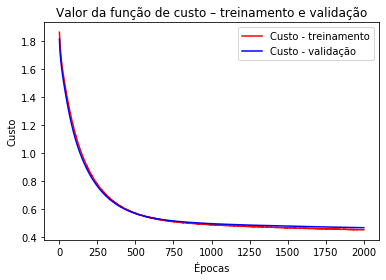

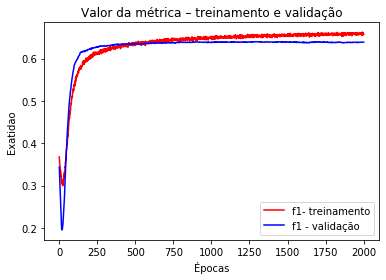

In [14]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [15]:
prob = np.ravel(model2.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.45155615696887685, 0.5026188242651657, 0.543925315954027, 0.5839642119752236, 0.6173000598053607, 0.6494325346784363, 0.6790980625537261, 0.7079523008266881, 0.7345362919613102, 0.76333515383215, 0.7929146870481305, 0.8222142515542803, 0.8505600453707642, 0.8771716469770674, 0.9039129428108359, 0.9310344827586207, 0.9710820895522388, 1.0]
recall values: [0.9440554494660159, 0.9094702595657401, 0.8736119951906075, 0.8401584270457599, 0.8030270881957705, 0.7649055803097815, 0.7263597142655067, 0.6844189829549473, 0.6391541127378174, 0.5931112525638306, 0.5429662635264163, 0.4863851757550039, 0.42428743192587876, 0.35709739019732656, 0.27611570832449256, 0.17759388924252067, 0.0736261404625504, 0.001697432633142372]
f1 values: [0.6109064280647154, 0.6474334768270271, 0.6704298740772905, 0.6890171398741336, 0.6980204106725686, 0.7024551831644582, 0.7019342491969106, 0.6959867663981588, 0.6835337720293473, 0.667542288557214, 0.6445573233701356, 0.6112073945696129, 0.566

Normalized confusion matrix
[[0.48389151 0.51610849]
 [0.05594455 0.94405545]]
Normalized confusion matrix
[[0.59490004 0.40509996]
 [0.09052974 0.90947026]]
Normalized confusion matrix
[[0.67028524 0.32971476]
 [0.126388   0.873612  ]]
Normalized confusion matrix
[[0.73058067 0.26941933]
 [0.15984157 0.84015843]]
Normalized confusion matrix
[[0.77591366 0.22408634]
 [0.19697291 0.80302709]]
Normalized confusion matrix
[[0.81414746 0.18585254]
 [0.23509442 0.76490558]]
Normalized confusion matrix
[[0.8455049  0.1544951 ]
 [0.27364029 0.72635971]]
Normalized confusion matrix
[[0.87291481 0.12708519]
 [0.31558102 0.68441898]]
Normalized confusion matrix
[[0.896027   0.103973  ]
 [0.36084589 0.63915411]]
Normalized confusion matrix
[[0.91722908 0.08277092]
 [0.40688875 0.59311125]]
Normalized confusion matrix
[[0.93617089 0.06382911]
 [0.45703374 0.54296626]]
Normalized confusion matrix
[[0.9526614  0.0473386 ]
 [0.51361482 0.48638518]]
Normalized confusion matrix
[[0.96644594 0.03355406]

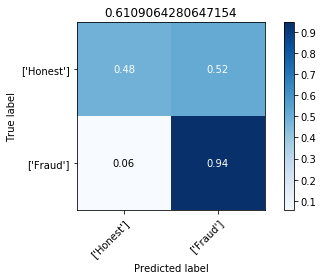

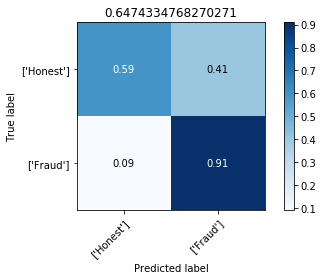

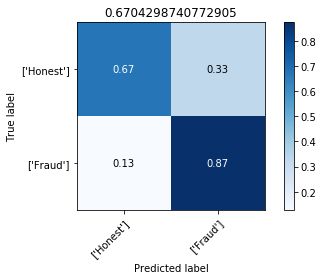

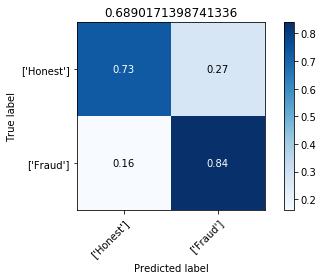

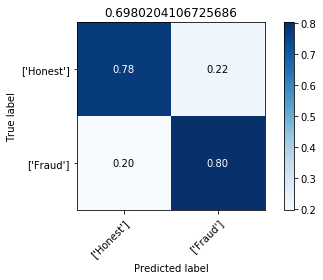

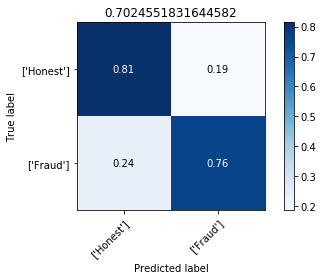

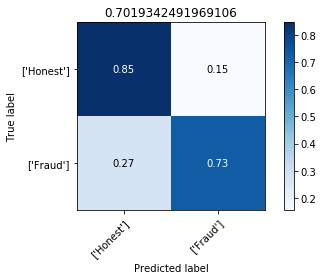

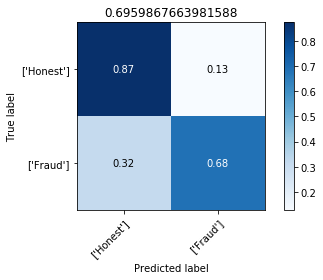

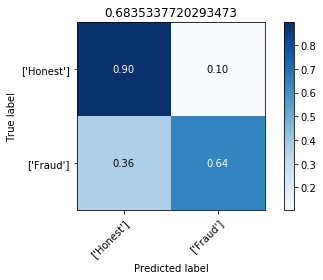

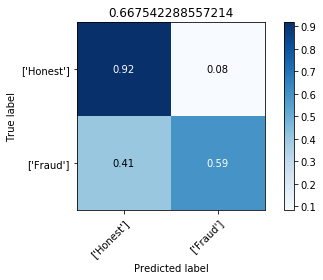

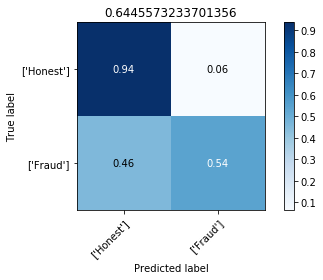

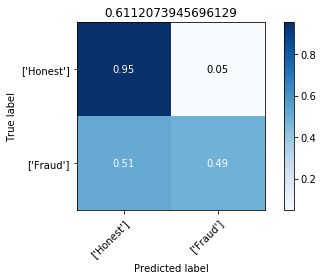

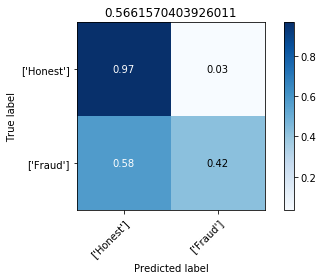

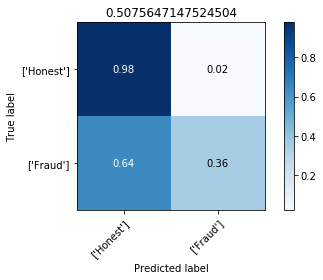

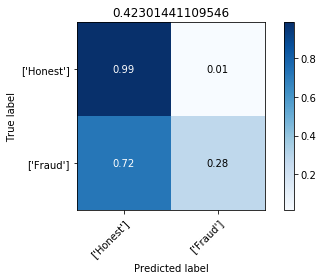

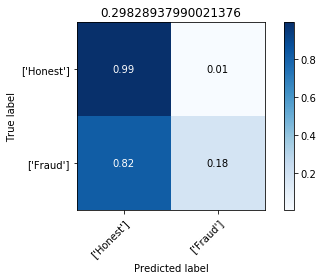

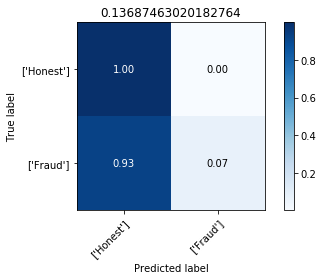

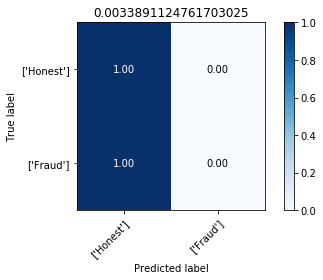

In [16]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [19]:
model2.save('/home/ricardo/TCC/Undersampling/models/RNA5/RNA5.h5')

In [17]:
K.clear_session()

In [18]:
model3 = models.Sequential()
model3.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
BatchNormalization(axis=1)
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
BatchNormalization(axis=1)
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(units = 1,activation = 'sigmoid'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

In [19]:
mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
model3.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model3.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val))

Train on 45551 samples, validate on 9761 samples
Epoch 1/2000
45551/45551 [==============================] - 3s 58us/step - loss: 2.7619 - f1Score: 0.3694 - val_loss: 2.6994 - val_f1Score: 0.3608
Epoch 2/2000
45551/45551 [==============================] - 2s 54us/step - loss: 2.7256 - f1Score: 0.3671 - val_loss: 2.6645 - val_f1Score: 0.3559
Epoch 3/2000
45551/45551 [==============================] - 2s 54us/step - loss: 2.6930 - f1Score: 0.3705 - val_loss: 2.6337 - val_f1Score: 0.3497
Epoch 4/2000
45551/45551 [==============================] - 2s 51us/step - loss: 2.6665 - f1Score: 0.3583 - val_loss: 2.6063 - val_f1Score: 0.3439
Epoch 5/2000
45551/45551 [==============================] - 2s 51us/step - loss: 2.6379 - f1Score: 0.3589 - val_loss: 2.5814 - val_f1Score: 0.3344
Epoch 6/2000
45551/45551 [==============================] - 2s 51us/step - loss: 2.6151 - f1Score: 0.3547 - val_loss: 2.5588 - val_f1Score: 0.3324
Epoch 7/2000
45551/45551 [==============================] - 2s 51us/s

45551/45551 [==============================] - 2s 50us/step - loss: 1.9800 - f1Score: 0.4353 - val_loss: 1.9378 - val_f1Score: 0.4605
Epoch 57/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.9718 - f1Score: 0.4405 - val_loss: 1.9281 - val_f1Score: 0.4649
Epoch 58/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.9613 - f1Score: 0.4473 - val_loss: 1.9185 - val_f1Score: 0.4710
Epoch 59/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.9523 - f1Score: 0.4458 - val_loss: 1.9089 - val_f1Score: 0.4776
Epoch 60/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.9428 - f1Score: 0.4570 - val_loss: 1.8994 - val_f1Score: 0.4816
Epoch 61/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.9316 - f1Score: 0.4602 - val_loss: 1.8900 - val_f1Score: 0.4879
Epoch 62/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.9228 - f1Score: 0.4654 - val_loss: 1.8806 

45551/45551 [==============================] - 2s 50us/step - loss: 1.2272 - f1Score: 0.5974 - val_loss: 1.2063 - val_f1Score: 0.6185
Epoch 167/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.2233 - f1Score: 0.5964 - val_loss: 1.2019 - val_f1Score: 0.6181
Epoch 168/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.2184 - f1Score: 0.5954 - val_loss: 1.1974 - val_f1Score: 0.6189
Epoch 169/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.2146 - f1Score: 0.5984 - val_loss: 1.1930 - val_f1Score: 0.6191
Epoch 170/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.2076 - f1Score: 0.5992 - val_loss: 1.1886 - val_f1Score: 0.6193
Epoch 171/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.2029 - f1Score: 0.6021 - val_loss: 1.1843 - val_f1Score: 0.6194
Epoch 172/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.2019 - f1Score: 0.5976 - val_loss: 1

45551/45551 [==============================] - 2s 50us/step - loss: 1.0096 - f1Score: 0.6128 - val_loss: 0.9965 - val_f1Score: 0.6248
Epoch 222/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.0054 - f1Score: 0.6139 - val_loss: 0.9933 - val_f1Score: 0.6248
Epoch 223/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.0035 - f1Score: 0.6122 - val_loss: 0.9901 - val_f1Score: 0.6245
Epoch 224/2000
45551/45551 [==============================] - 2s 50us/step - loss: 1.0000 - f1Score: 0.6134 - val_loss: 0.9869 - val_f1Score: 0.6245
Epoch 225/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.9969 - f1Score: 0.6126 - val_loss: 0.9838 - val_f1Score: 0.6243
Epoch 226/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.9943 - f1Score: 0.6117 - val_loss: 0.9806 - val_f1Score: 0.6245
Epoch 227/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.9899 - f1Score: 0.6129 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.8558 - f1Score: 0.6200 - val_loss: 0.8451 - val_f1Score: 0.6317
Epoch 277/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.8519 - f1Score: 0.6220 - val_loss: 0.8428 - val_f1Score: 0.6315
Epoch 278/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.8478 - f1Score: 0.6237 - val_loss: 0.8405 - val_f1Score: 0.6313
Epoch 279/2000
45551/45551 [==============================] - 2s 54us/step - loss: 0.8466 - f1Score: 0.6176 - val_loss: 0.8382 - val_f1Score: 0.6313
Epoch 280/2000
45551/45551 [==============================] - 2s 54us/step - loss: 0.8438 - f1Score: 0.6224 - val_loss: 0.8359 - val_f1Score: 0.6320
Epoch 281/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.8412 - f1Score: 0.6230 - val_loss: 0.8336 - val_f1Score: 0.6315
Epoch 282/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.8390 - f1Score: 0.6250 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.7425 - f1Score: 0.6206 - val_loss: 0.7353 - val_f1Score: 0.6341
Epoch 332/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.7365 - f1Score: 0.6294 - val_loss: 0.7336 - val_f1Score: 0.6345
Epoch 333/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.7373 - f1Score: 0.6255 - val_loss: 0.7319 - val_f1Score: 0.6347
Epoch 334/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.7341 - f1Score: 0.6281 - val_loss: 0.7302 - val_f1Score: 0.6349
Epoch 335/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.7327 - f1Score: 0.6272 - val_loss: 0.7286 - val_f1Score: 0.6348
Epoch 336/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.7315 - f1Score: 0.6242 - val_loss: 0.7269 - val_f1Score: 0.6352
Epoch 337/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.7302 - f1Score: 0.6287 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.6572 - f1Score: 0.6290 - val_loss: 0.6554 - val_f1Score: 0.6354
Epoch 387/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.6570 - f1Score: 0.6273 - val_loss: 0.6542 - val_f1Score: 0.6353
Epoch 388/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.6535 - f1Score: 0.6288 - val_loss: 0.6529 - val_f1Score: 0.6351
Epoch 389/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.6551 - f1Score: 0.6309 - val_loss: 0.6517 - val_f1Score: 0.6350
Epoch 390/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.6521 - f1Score: 0.6312 - val_loss: 0.6505 - val_f1Score: 0.6349
Epoch 391/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.6503 - f1Score: 0.6286 - val_loss: 0.6493 - val_f1Score: 0.6345
Epoch 392/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.6488 - f1Score: 0.6306 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.5983 - f1Score: 0.6313 - val_loss: 0.5973 - val_f1Score: 0.6366
Epoch 442/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5954 - f1Score: 0.6340 - val_loss: 0.5965 - val_f1Score: 0.6365
Epoch 443/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5953 - f1Score: 0.6342 - val_loss: 0.5956 - val_f1Score: 0.6374
Epoch 444/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5935 - f1Score: 0.6354 - val_loss: 0.5947 - val_f1Score: 0.6364
Epoch 445/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5927 - f1Score: 0.6360 - val_loss: 0.5938 - val_f1Score: 0.6370
Epoch 446/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5918 - f1Score: 0.6315 - val_loss: 0.5929 - val_f1Score: 0.6369
Epoch 447/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5909 - f1Score: 0.6351 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.5526 - f1Score: 0.6345 - val_loss: 0.5550 - val_f1Score: 0.6378
Epoch 497/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5518 - f1Score: 0.6367 - val_loss: 0.5543 - val_f1Score: 0.6379
Epoch 498/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.5523 - f1Score: 0.6348 - val_loss: 0.5537 - val_f1Score: 0.6383
Epoch 499/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5508 - f1Score: 0.6369 - val_loss: 0.5530 - val_f1Score: 0.6381
Epoch 500/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.5510 - f1Score: 0.6389 - val_loss: 0.5524 - val_f1Score: 0.6382
Epoch 501/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.5495 - f1Score: 0.6373 - val_loss: 0.5517 - val_f1Score: 0.6381
Epoch 502/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5479 - f1Score: 0.6393 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.5207 - f1Score: 0.6385 - val_loss: 0.5241 - val_f1Score: 0.6391
Epoch 552/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.5201 - f1Score: 0.6380 - val_loss: 0.5236 - val_f1Score: 0.6389
Epoch 553/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5200 - f1Score: 0.6377 - val_loss: 0.5231 - val_f1Score: 0.6388
Epoch 554/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5200 - f1Score: 0.6387 - val_loss: 0.5226 - val_f1Score: 0.6390
Epoch 555/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5199 - f1Score: 0.6391 - val_loss: 0.5222 - val_f1Score: 0.6392
Epoch 556/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5189 - f1Score: 0.6376 - val_loss: 0.5217 - val_f1Score: 0.6390
Epoch 557/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.5181 - f1Score: 0.6397 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.4976 - f1Score: 0.6402 - val_loss: 0.5015 - val_f1Score: 0.6390
Epoch 607/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4972 - f1Score: 0.6389 - val_loss: 0.5011 - val_f1Score: 0.6388
Epoch 608/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4967 - f1Score: 0.6385 - val_loss: 0.5008 - val_f1Score: 0.6388
Epoch 609/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4955 - f1Score: 0.6406 - val_loss: 0.5004 - val_f1Score: 0.6389
Epoch 610/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4952 - f1Score: 0.6410 - val_loss: 0.5001 - val_f1Score: 0.6389
Epoch 611/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4950 - f1Score: 0.6428 - val_loss: 0.4998 - val_f1Score: 0.6389
Epoch 612/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4941 - f1Score: 0.6432 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.4795 - f1Score: 0.6419 - val_loss: 0.4849 - val_f1Score: 0.6394
Epoch 662/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4789 - f1Score: 0.6411 - val_loss: 0.4847 - val_f1Score: 0.6398
Epoch 663/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4798 - f1Score: 0.6395 - val_loss: 0.4844 - val_f1Score: 0.6393
Epoch 664/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4796 - f1Score: 0.6401 - val_loss: 0.4842 - val_f1Score: 0.6393
Epoch 665/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4782 - f1Score: 0.6417 - val_loss: 0.4839 - val_f1Score: 0.6393
Epoch 666/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4780 - f1Score: 0.6424 - val_loss: 0.4837 - val_f1Score: 0.6395
Epoch 667/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4776 - f1Score: 0.6425 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4665 - f1Score: 0.6458 - val_loss: 0.4729 - val_f1Score: 0.6395
Epoch 717/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4674 - f1Score: 0.6419 - val_loss: 0.4727 - val_f1Score: 0.6395
Epoch 718/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4664 - f1Score: 0.6428 - val_loss: 0.4725 - val_f1Score: 0.6395
Epoch 719/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4656 - f1Score: 0.6449 - val_loss: 0.4723 - val_f1Score: 0.6399
Epoch 720/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4664 - f1Score: 0.6413 - val_loss: 0.4721 - val_f1Score: 0.6399
Epoch 721/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4655 - f1Score: 0.6423 - val_loss: 0.4719 - val_f1Score: 0.6402
Epoch 722/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4659 - f1Score: 0.6405 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.4589 - f1Score: 0.6431 - val_loss: 0.4640 - val_f1Score: 0.6400
Epoch 772/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4578 - f1Score: 0.6467 - val_loss: 0.4638 - val_f1Score: 0.6396
Epoch 773/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4569 - f1Score: 0.6460 - val_loss: 0.4637 - val_f1Score: 0.6394
Epoch 774/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4566 - f1Score: 0.6454 - val_loss: 0.4635 - val_f1Score: 0.6396
Epoch 775/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4569 - f1Score: 0.6440 - val_loss: 0.4634 - val_f1Score: 0.6396
Epoch 776/2000
45551/45551 [==============================] - 2s 54us/step - loss: 0.4553 - f1Score: 0.6438 - val_loss: 0.4633 - val_f1Score: 0.6394
Epoch 777/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4567 - f1Score: 0.6465 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.4499 - f1Score: 0.6409 - val_loss: 0.4574 - val_f1Score: 0.6394
Epoch 827/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4497 - f1Score: 0.6477 - val_loss: 0.4573 - val_f1Score: 0.6395
Epoch 828/2000
45551/45551 [==============================] - 2s 53us/step - loss: 0.4492 - f1Score: 0.6441 - val_loss: 0.4572 - val_f1Score: 0.6398
Epoch 829/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4506 - f1Score: 0.6446 - val_loss: 0.4571 - val_f1Score: 0.6395
Epoch 830/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4485 - f1Score: 0.6511 - val_loss: 0.4570 - val_f1Score: 0.6392
Epoch 831/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4499 - f1Score: 0.6411 - val_loss: 0.4569 - val_f1Score: 0.6393
Epoch 832/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4496 - f1Score: 0.6434 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.4459 - f1Score: 0.6437 - val_loss: 0.4526 - val_f1Score: 0.6403
Epoch 882/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4447 - f1Score: 0.6475 - val_loss: 0.4525 - val_f1Score: 0.6404
Epoch 883/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4452 - f1Score: 0.6452 - val_loss: 0.4524 - val_f1Score: 0.6404
Epoch 884/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4444 - f1Score: 0.6480 - val_loss: 0.4524 - val_f1Score: 0.6403
Epoch 885/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4430 - f1Score: 0.6471 - val_loss: 0.4523 - val_f1Score: 0.6405
Epoch 886/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4441 - f1Score: 0.6480 - val_loss: 0.4522 - val_f1Score: 0.6403
Epoch 887/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4447 - f1Score: 0.6478 - val_loss: 0

45551/45551 [==============================] - 2s 53us/step - loss: 0.4403 - f1Score: 0.6475 - val_loss: 0.4490 - val_f1Score: 0.6411
Epoch 937/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4406 - f1Score: 0.6447 - val_loss: 0.4490 - val_f1Score: 0.6408
Epoch 938/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4399 - f1Score: 0.6477 - val_loss: 0.4489 - val_f1Score: 0.6404
Epoch 939/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4399 - f1Score: 0.6500 - val_loss: 0.4489 - val_f1Score: 0.6401
Epoch 940/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4404 - f1Score: 0.6495 - val_loss: 0.4488 - val_f1Score: 0.6404
Epoch 941/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4402 - f1Score: 0.6475 - val_loss: 0.4487 - val_f1Score: 0.6416
Epoch 942/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4391 - f1Score: 0.6485 - val_loss: 0

45551/45551 [==============================] - 2s 50us/step - loss: 0.4378 - f1Score: 0.6497 - val_loss: 0.4464 - val_f1Score: 0.6424
Epoch 992/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4355 - f1Score: 0.6458 - val_loss: 0.4463 - val_f1Score: 0.6426
Epoch 993/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4377 - f1Score: 0.6462 - val_loss: 0.4463 - val_f1Score: 0.6423
Epoch 994/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4371 - f1Score: 0.6449 - val_loss: 0.4462 - val_f1Score: 0.6419
Epoch 995/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4369 - f1Score: 0.6476 - val_loss: 0.4462 - val_f1Score: 0.6423
Epoch 996/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4366 - f1Score: 0.6487 - val_loss: 0.4462 - val_f1Score: 0.6424
Epoch 997/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4366 - f1Score: 0.6471 - val_loss: 0

Epoch 1046/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4351 - f1Score: 0.6481 - val_loss: 0.4443 - val_f1Score: 0.6429
Epoch 1047/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4344 - f1Score: 0.6524 - val_loss: 0.4443 - val_f1Score: 0.6430
Epoch 1048/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4348 - f1Score: 0.6456 - val_loss: 0.4443 - val_f1Score: 0.6430
Epoch 1049/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4351 - f1Score: 0.6483 - val_loss: 0.4443 - val_f1Score: 0.6430
Epoch 1050/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4349 - f1Score: 0.6478 - val_loss: 0.4442 - val_f1Score: 0.6430
Epoch 1051/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4346 - f1Score: 0.6473 - val_loss: 0.4442 - val_f1Score: 0.6430
Epoch 1052/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4356 - f1Score

Epoch 1155/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4304 - f1Score: 0.6525 - val_loss: 0.4417 - val_f1Score: 0.6421
Epoch 1156/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4318 - f1Score: 0.6471 - val_loss: 0.4417 - val_f1Score: 0.6424
Epoch 1157/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4308 - f1Score: 0.6509 - val_loss: 0.4417 - val_f1Score: 0.6433
Epoch 1158/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4310 - f1Score: 0.6497 - val_loss: 0.4417 - val_f1Score: 0.6430
Epoch 1159/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4315 - f1Score: 0.6468 - val_loss: 0.4417 - val_f1Score: 0.6436
Epoch 1160/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4324 - f1Score: 0.6506 - val_loss: 0.4416 - val_f1Score: 0.6437
Epoch 1161/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4311 - f1Score

Epoch 1264/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4285 - f1Score: 0.6533 - val_loss: 0.4402 - val_f1Score: 0.6439
Epoch 1265/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4289 - f1Score: 0.6482 - val_loss: 0.4402 - val_f1Score: 0.6436
Epoch 1266/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4304 - f1Score: 0.6482 - val_loss: 0.4402 - val_f1Score: 0.6436
Epoch 1267/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4284 - f1Score: 0.6504 - val_loss: 0.4402 - val_f1Score: 0.6433
Epoch 1268/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4289 - f1Score: 0.6531 - val_loss: 0.4402 - val_f1Score: 0.6434
Epoch 1269/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4290 - f1Score: 0.6515 - val_loss: 0.4402 - val_f1Score: 0.6435
Epoch 1270/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4296 - f1Score

Epoch 1373/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4271 - f1Score: 0.6547 - val_loss: 0.4392 - val_f1Score: 0.6429
Epoch 1374/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4275 - f1Score: 0.6562 - val_loss: 0.4392 - val_f1Score: 0.6429
Epoch 1375/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4263 - f1Score: 0.6519 - val_loss: 0.4393 - val_f1Score: 0.6434
Epoch 1376/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4279 - f1Score: 0.6511 - val_loss: 0.4392 - val_f1Score: 0.6437
Epoch 1377/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4272 - f1Score: 0.6540 - val_loss: 0.4392 - val_f1Score: 0.6433
Epoch 1378/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4269 - f1Score: 0.6536 - val_loss: 0.4392 - val_f1Score: 0.6433
Epoch 1379/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4271 - f1Score

Epoch 1482/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4259 - f1Score: 0.6560 - val_loss: 0.4387 - val_f1Score: 0.6434
Epoch 1483/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4262 - f1Score: 0.6502 - val_loss: 0.4387 - val_f1Score: 0.6432
Epoch 1484/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4260 - f1Score: 0.6516 - val_loss: 0.4387 - val_f1Score: 0.6426
Epoch 1485/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4264 - f1Score: 0.6509 - val_loss: 0.4386 - val_f1Score: 0.6427
Epoch 1486/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4257 - f1Score: 0.6507 - val_loss: 0.4386 - val_f1Score: 0.6427
Epoch 1487/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4258 - f1Score: 0.6516 - val_loss: 0.4386 - val_f1Score: 0.6427
Epoch 1488/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4250 - f1Score

Epoch 1591/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4245 - f1Score: 0.6539 - val_loss: 0.4382 - val_f1Score: 0.6440
Epoch 1592/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4244 - f1Score: 0.6556 - val_loss: 0.4382 - val_f1Score: 0.6440
Epoch 1593/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4256 - f1Score: 0.6571 - val_loss: 0.4382 - val_f1Score: 0.6442
Epoch 1594/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4249 - f1Score: 0.6545 - val_loss: 0.4382 - val_f1Score: 0.6443
Epoch 1595/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4259 - f1Score: 0.6510 - val_loss: 0.4382 - val_f1Score: 0.6437
Epoch 1596/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4248 - f1Score: 0.6539 - val_loss: 0.4382 - val_f1Score: 0.6440
Epoch 1597/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4239 - f1Score

Epoch 1700/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4248 - f1Score: 0.6563 - val_loss: 0.4379 - val_f1Score: 0.6439
Epoch 1701/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4228 - f1Score: 0.6555 - val_loss: 0.4379 - val_f1Score: 0.6438
Epoch 1702/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4240 - f1Score: 0.6540 - val_loss: 0.4379 - val_f1Score: 0.6438
Epoch 1703/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4235 - f1Score: 0.6536 - val_loss: 0.4379 - val_f1Score: 0.6441
Epoch 1704/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4244 - f1Score: 0.6551 - val_loss: 0.4379 - val_f1Score: 0.6438
Epoch 1705/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4240 - f1Score: 0.6559 - val_loss: 0.4379 - val_f1Score: 0.6437
Epoch 1706/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4236 - f1Score

Epoch 1809/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4233 - f1Score: 0.6561 - val_loss: 0.4376 - val_f1Score: 0.6435
Epoch 1810/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4229 - f1Score: 0.6552 - val_loss: 0.4376 - val_f1Score: 0.6439
Epoch 1811/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4232 - f1Score: 0.6546 - val_loss: 0.4376 - val_f1Score: 0.6439
Epoch 1812/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4237 - f1Score: 0.6567 - val_loss: 0.4376 - val_f1Score: 0.6437
Epoch 1813/2000
45551/45551 [==============================] - 2s 53us/step - loss: 0.4233 - f1Score: 0.6547 - val_loss: 0.4376 - val_f1Score: 0.6435
Epoch 1814/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4231 - f1Score: 0.6536 - val_loss: 0.4376 - val_f1Score: 0.6431
Epoch 1815/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4234 - f1Score

Epoch 1918/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4227 - f1Score: 0.6590 - val_loss: 0.4375 - val_f1Score: 0.6432
Epoch 1919/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4228 - f1Score: 0.6533 - val_loss: 0.4375 - val_f1Score: 0.6433
Epoch 1920/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4225 - f1Score: 0.6569 - val_loss: 0.4375 - val_f1Score: 0.6433
Epoch 1921/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4224 - f1Score: 0.6567 - val_loss: 0.4375 - val_f1Score: 0.6434
Epoch 1922/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4218 - f1Score: 0.6568 - val_loss: 0.4375 - val_f1Score: 0.6432
Epoch 1923/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4230 - f1Score: 0.6578 - val_loss: 0.4374 - val_f1Score: 0.6434
Epoch 1924/2000
45551/45551 [==============================] - 2s 50us/step - loss: 0.4225 - f1Score

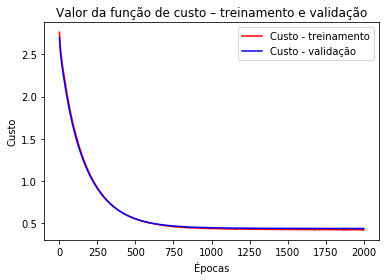

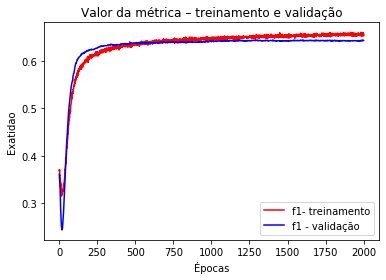

In [20]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [21]:
prob = np.ravel(model3.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.44048126413795363, 0.49105721864342555, 0.5356404068264092, 0.5769752130131681, 0.6137276180141075, 0.6489869972785002, 0.6826165960024227, 0.7127755285650023, 0.7453500169090295, 0.7773302646720368, 0.8050632911392405, 0.8344694533762058, 0.8615954328035796, 0.8888463745934571, 0.915721649484536, 0.9392580513656746, 0.9752520623281393, 1.0]
recall values: [0.9502793691208713, 0.9165428955371667, 0.879057924888606, 0.8429167550746163, 0.7999858547280572, 0.7589645660937832, 0.717377466581795, 0.6723955018035221, 0.6235235872409647, 0.5733078718438362, 0.5172925949501379, 0.4588726218261546, 0.3949359926444586, 0.32859466723247754, 0.25129075606478535, 0.16295353278166771, 0.0752528467359785, 0.00770917320885494]
f1 values: [0.6019443573316607, 0.6394927089244739, 0.6656669255282114, 0.6850409541600805, 0.6945868770917131, 0.6996805111821087, 0.6995654872749845, 0.6919969428976963, 0.6790156737397466, 0.6599096348760533, 0.6298656562177058, 0.5921328830884367, 0.541

Normalized confusion matrix
[[0.45667261 0.54332739]
 [0.04972063 0.95027937]]
Normalized confusion matrix
[[0.57242455 0.42757545]
 [0.0834571  0.9165429 ]]
Normalized confusion matrix
[[0.65697822 0.34302178]
 [0.12094208 0.87905792]]
Normalized confusion matrix
[[0.72182605 0.27817395]
 [0.15708324 0.84291676]]
Normalized confusion matrix
[[0.77336687 0.22663313]
 [0.20001415 0.79998585]]
Normalized confusion matrix
[[0.81522985 0.18477015]
 [0.24103543 0.75896457]]
Normalized confusion matrix
[[0.84986629 0.15013371]
 [0.28262253 0.71737747]]
Normalized confusion matrix
[[0.87804024 0.12195976]
 [0.3276045  0.6723955 ]]
Normalized confusion matrix
[[0.90411308 0.09588692]
 [0.37647641 0.62352359]]
Normalized confusion matrix
[[0.92607921 0.07392079]
 [0.42669213 0.57330787]]
Normalized confusion matrix
[[0.94362027 0.05637973]
 [0.48270741 0.51729259]]
Normalized confusion matrix
[[0.9590284  0.0409716 ]
 [0.54112738 0.45887262]]
Normalized confusion matrix
[[0.97144403 0.02855597]

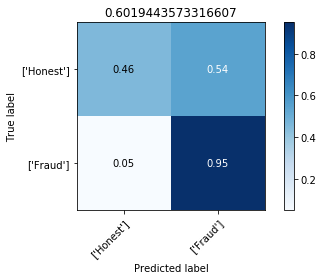

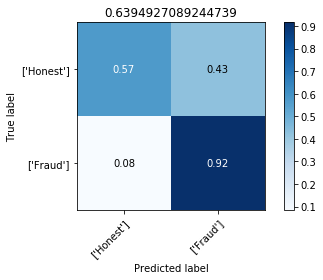

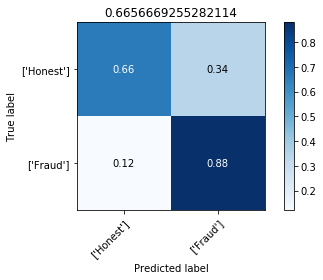

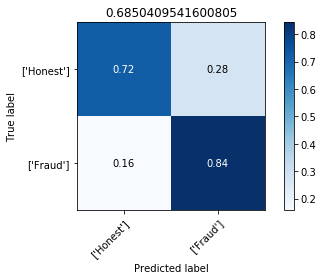

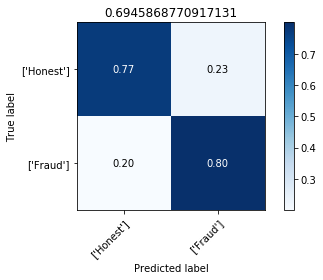

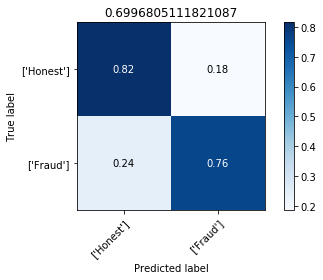

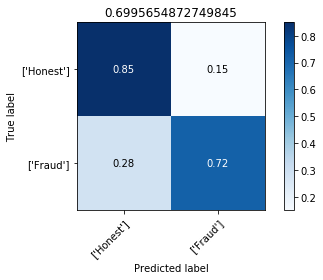

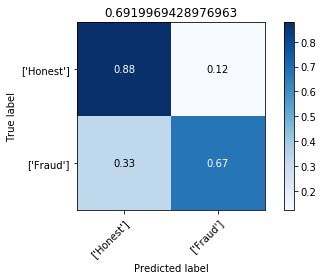

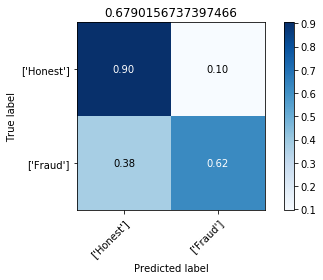

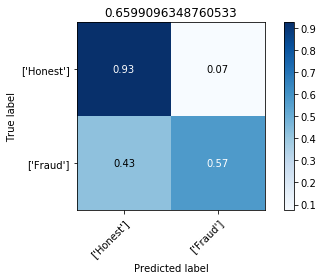

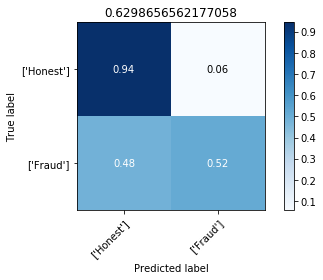

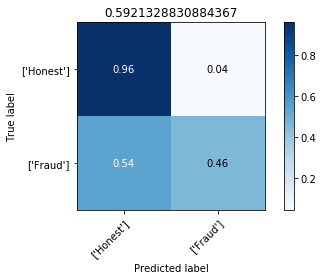

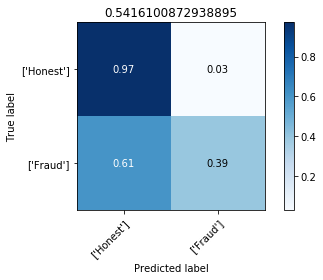

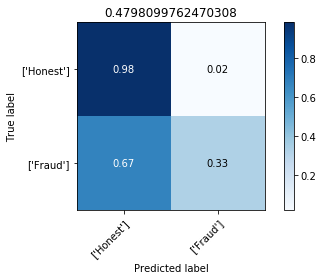

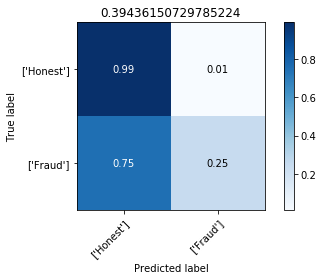

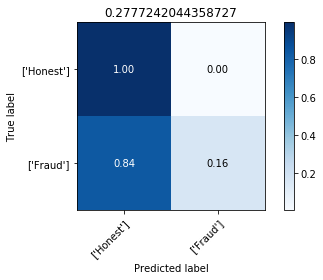

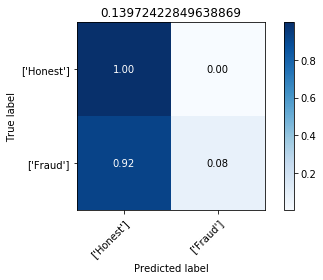

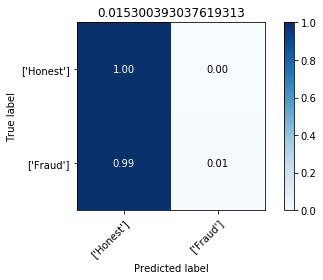

In [22]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [23]:
K.clear_session()

In [24]:
model4 = models.Sequential()
model4.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,),
                        kernel_regularizer=regularizers.l2(0.0001)))
BatchNormalization(axis=1)
model4.add(layers.Dropout(0.3))
model4.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
BatchNormalization(axis=1)
model4.add(layers.Dropout(0.3))
model4.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
BatchNormalization(axis=1)
model4.add(layers.Dropout(0.3))
model4.add(layers.Dense(units = 1,activation = 'sigmoid'))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

In [25]:
mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
model4.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model4.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val))

Train on 45551 samples, validate on 9761 samples
Epoch 1/2000
45551/45551 [==============================] - 3s 59us/step - loss: 2.8256 - f1Score: 0.3677 - val_loss: 2.7651 - val_f1Score: 0.3620
Epoch 2/2000
45551/45551 [==============================] - 3s 55us/step - loss: 2.7889 - f1Score: 0.3601 - val_loss: 2.7257 - val_f1Score: 0.3609
Epoch 3/2000
45551/45551 [==============================] - 3s 56us/step - loss: 2.7514 - f1Score: 0.3653 - val_loss: 2.6916 - val_f1Score: 0.3605
Epoch 4/2000
45551/45551 [==============================] - 2s 52us/step - loss: 2.7198 - f1Score: 0.3618 - val_loss: 2.6615 - val_f1Score: 0.3570
Epoch 5/2000
45551/45551 [==============================] - 2s 52us/step - loss: 2.6930 - f1Score: 0.3561 - val_loss: 2.6345 - val_f1Score: 0.3561
Epoch 6/2000
45551/45551 [==============================] - 2s 52us/step - loss: 2.6656 - f1Score: 0.3586 - val_loss: 2.6100 - val_f1Score: 0.3506
Epoch 7/2000
45551/45551 [==============================] - 2s 52us/s

45551/45551 [==============================] - 2s 51us/step - loss: 2.0146 - f1Score: 0.4483 - val_loss: 1.9725 - val_f1Score: 0.4856
Epoch 57/2000
45551/45551 [==============================] - 2s 51us/step - loss: 2.0063 - f1Score: 0.4475 - val_loss: 1.9628 - val_f1Score: 0.4915
Epoch 58/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.9956 - f1Score: 0.4491 - val_loss: 1.9531 - val_f1Score: 0.4961
Epoch 59/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.9846 - f1Score: 0.4528 - val_loss: 1.9434 - val_f1Score: 0.5002
Epoch 60/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.9774 - f1Score: 0.4538 - val_loss: 1.9339 - val_f1Score: 0.5026
Epoch 61/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.9692 - f1Score: 0.4639 - val_loss: 1.9245 - val_f1Score: 0.5061
Epoch 62/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.9593 - f1Score: 0.4630 - val_loss: 1.9151 

45551/45551 [==============================] - 2s 51us/step - loss: 1.2546 - f1Score: 0.5951 - val_loss: 1.2313 - val_f1Score: 0.6262
Epoch 167/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.2478 - f1Score: 0.5953 - val_loss: 1.2268 - val_f1Score: 0.6265
Epoch 168/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.2445 - f1Score: 0.5957 - val_loss: 1.2222 - val_f1Score: 0.6268
Epoch 169/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.2395 - f1Score: 0.5951 - val_loss: 1.2178 - val_f1Score: 0.6264
Epoch 170/2000
45551/45551 [==============================] - 2s 54us/step - loss: 1.2347 - f1Score: 0.5984 - val_loss: 1.2133 - val_f1Score: 0.6272
Epoch 171/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.2301 - f1Score: 0.6007 - val_loss: 1.2089 - val_f1Score: 0.6265
Epoch 172/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.2261 - f1Score: 0.5998 - val_loss: 1

45551/45551 [==============================] - 2s 51us/step - loss: 1.0328 - f1Score: 0.6127 - val_loss: 1.0182 - val_f1Score: 0.6283
Epoch 222/2000
45551/45551 [==============================] - 2s 54us/step - loss: 1.0285 - f1Score: 0.6149 - val_loss: 1.0149 - val_f1Score: 0.6283
Epoch 223/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.0264 - f1Score: 0.6130 - val_loss: 1.0117 - val_f1Score: 0.6288
Epoch 224/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.0241 - f1Score: 0.6082 - val_loss: 1.0085 - val_f1Score: 0.6289
Epoch 225/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.0180 - f1Score: 0.6116 - val_loss: 1.0053 - val_f1Score: 0.6292
Epoch 226/2000
45551/45551 [==============================] - 2s 53us/step - loss: 1.0177 - f1Score: 0.6174 - val_loss: 1.0021 - val_f1Score: 0.6290
Epoch 227/2000
45551/45551 [==============================] - 2s 51us/step - loss: 1.0114 - f1Score: 0.6165 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.8737 - f1Score: 0.6190 - val_loss: 0.8644 - val_f1Score: 0.6294
Epoch 277/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.8717 - f1Score: 0.6180 - val_loss: 0.8621 - val_f1Score: 0.6289
Epoch 278/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.8670 - f1Score: 0.6263 - val_loss: 0.8597 - val_f1Score: 0.6289
Epoch 279/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.8656 - f1Score: 0.6242 - val_loss: 0.8574 - val_f1Score: 0.6288
Epoch 280/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.8626 - f1Score: 0.6238 - val_loss: 0.8551 - val_f1Score: 0.6294
Epoch 281/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.8620 - f1Score: 0.6202 - val_loss: 0.8528 - val_f1Score: 0.6294
Epoch 282/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.8594 - f1Score: 0.6216 - val_loss: 0

45551/45551 [==============================] - 2s 52us/step - loss: 0.7601 - f1Score: 0.6240 - val_loss: 0.7529 - val_f1Score: 0.6302
Epoch 332/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.7559 - f1Score: 0.6233 - val_loss: 0.7511 - val_f1Score: 0.6309
Epoch 333/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.7559 - f1Score: 0.6253 - val_loss: 0.7494 - val_f1Score: 0.6306
Epoch 334/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.7539 - f1Score: 0.6254 - val_loss: 0.7477 - val_f1Score: 0.6307
Epoch 335/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.7512 - f1Score: 0.6243 - val_loss: 0.7460 - val_f1Score: 0.6306
Epoch 336/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.7506 - f1Score: 0.6247 - val_loss: 0.7444 - val_f1Score: 0.6301
Epoch 337/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.7479 - f1Score: 0.6273 - val_loss: 0

45551/45551 [==============================] - 2s 52us/step - loss: 0.6749 - f1Score: 0.6283 - val_loss: 0.6718 - val_f1Score: 0.6285
Epoch 387/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.6739 - f1Score: 0.6319 - val_loss: 0.6705 - val_f1Score: 0.6280
Epoch 388/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.6730 - f1Score: 0.6323 - val_loss: 0.6693 - val_f1Score: 0.6283
Epoch 389/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.6703 - f1Score: 0.6329 - val_loss: 0.6680 - val_f1Score: 0.6281
Epoch 390/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.6684 - f1Score: 0.6333 - val_loss: 0.6668 - val_f1Score: 0.6281
Epoch 391/2000
45551/45551 [==============================] - 2s 54us/step - loss: 0.6669 - f1Score: 0.6267 - val_loss: 0.6656 - val_f1Score: 0.6280
Epoch 392/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.6677 - f1Score: 0.6281 - val_loss: 0

45551/45551 [==============================] - 2s 52us/step - loss: 0.6145 - f1Score: 0.6343 - val_loss: 0.6127 - val_f1Score: 0.6303
Epoch 442/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.6135 - f1Score: 0.6345 - val_loss: 0.6118 - val_f1Score: 0.6297
Epoch 443/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.6120 - f1Score: 0.6374 - val_loss: 0.6109 - val_f1Score: 0.6297
Epoch 444/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.6096 - f1Score: 0.6334 - val_loss: 0.6100 - val_f1Score: 0.6299
Epoch 445/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.6095 - f1Score: 0.6327 - val_loss: 0.6091 - val_f1Score: 0.6302
Epoch 446/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.6088 - f1Score: 0.6337 - val_loss: 0.6082 - val_f1Score: 0.6302
Epoch 447/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.6076 - f1Score: 0.6321 - val_loss: 0

45551/45551 [==============================] - 2s 52us/step - loss: 0.5689 - f1Score: 0.6376 - val_loss: 0.5696 - val_f1Score: 0.6288
Epoch 497/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5684 - f1Score: 0.6316 - val_loss: 0.5690 - val_f1Score: 0.6296
Epoch 498/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5686 - f1Score: 0.6381 - val_loss: 0.5683 - val_f1Score: 0.6297
Epoch 499/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5668 - f1Score: 0.6349 - val_loss: 0.5676 - val_f1Score: 0.6291
Epoch 500/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5655 - f1Score: 0.6365 - val_loss: 0.5670 - val_f1Score: 0.6296
Epoch 501/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5637 - f1Score: 0.6393 - val_loss: 0.5664 - val_f1Score: 0.6295
Epoch 502/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5643 - f1Score: 0.6361 - val_loss: 0

45551/45551 [==============================] - 2s 52us/step - loss: 0.5369 - f1Score: 0.6363 - val_loss: 0.5382 - val_f1Score: 0.6302
Epoch 552/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5362 - f1Score: 0.6368 - val_loss: 0.5377 - val_f1Score: 0.6302
Epoch 553/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5333 - f1Score: 0.6444 - val_loss: 0.5372 - val_f1Score: 0.6304
Epoch 554/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5351 - f1Score: 0.6404 - val_loss: 0.5367 - val_f1Score: 0.6300
Epoch 555/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5337 - f1Score: 0.6384 - val_loss: 0.5363 - val_f1Score: 0.6300
Epoch 556/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5340 - f1Score: 0.6361 - val_loss: 0.5358 - val_f1Score: 0.6302
Epoch 557/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5319 - f1Score: 0.6411 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.5106 - f1Score: 0.6394 - val_loss: 0.5152 - val_f1Score: 0.6300
Epoch 607/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5113 - f1Score: 0.6414 - val_loss: 0.5148 - val_f1Score: 0.6299
Epoch 608/2000
45551/45551 [==============================] - 2s 53us/step - loss: 0.5113 - f1Score: 0.6386 - val_loss: 0.5145 - val_f1Score: 0.6299
Epoch 609/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5104 - f1Score: 0.6408 - val_loss: 0.5141 - val_f1Score: 0.6299
Epoch 610/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.5091 - f1Score: 0.6421 - val_loss: 0.5138 - val_f1Score: 0.6302
Epoch 611/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5084 - f1Score: 0.6425 - val_loss: 0.5134 - val_f1Score: 0.6303
Epoch 612/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.5096 - f1Score: 0.6416 - val_loss: 0

45551/45551 [==============================] - 2s 52us/step - loss: 0.4942 - f1Score: 0.6444 - val_loss: 0.4984 - val_f1Score: 0.6307
Epoch 662/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4933 - f1Score: 0.6399 - val_loss: 0.4981 - val_f1Score: 0.6307
Epoch 663/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4944 - f1Score: 0.6430 - val_loss: 0.4978 - val_f1Score: 0.6307
Epoch 664/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4926 - f1Score: 0.6435 - val_loss: 0.4976 - val_f1Score: 0.6304
Epoch 665/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4928 - f1Score: 0.6434 - val_loss: 0.4973 - val_f1Score: 0.6305
Epoch 666/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4927 - f1Score: 0.6460 - val_loss: 0.4970 - val_f1Score: 0.6301
Epoch 667/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4928 - f1Score: 0.6434 - val_loss: 0

45551/45551 [==============================] - 2s 52us/step - loss: 0.4805 - f1Score: 0.6429 - val_loss: 0.4860 - val_f1Score: 0.6322
Epoch 717/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4798 - f1Score: 0.6418 - val_loss: 0.4858 - val_f1Score: 0.6322
Epoch 718/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4799 - f1Score: 0.6462 - val_loss: 0.4856 - val_f1Score: 0.6322
Epoch 719/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4791 - f1Score: 0.6460 - val_loss: 0.4854 - val_f1Score: 0.6325
Epoch 720/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4803 - f1Score: 0.6444 - val_loss: 0.4852 - val_f1Score: 0.6324
Epoch 721/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4795 - f1Score: 0.6418 - val_loss: 0.4851 - val_f1Score: 0.6320
Epoch 722/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4802 - f1Score: 0.6436 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4704 - f1Score: 0.6463 - val_loss: 0.4770 - val_f1Score: 0.6318
Epoch 772/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4716 - f1Score: 0.6431 - val_loss: 0.4768 - val_f1Score: 0.6315
Epoch 773/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4707 - f1Score: 0.6466 - val_loss: 0.4767 - val_f1Score: 0.6315
Epoch 774/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4689 - f1Score: 0.6472 - val_loss: 0.4765 - val_f1Score: 0.6315
Epoch 775/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4707 - f1Score: 0.6452 - val_loss: 0.4764 - val_f1Score: 0.6315
Epoch 776/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4700 - f1Score: 0.6455 - val_loss: 0.4762 - val_f1Score: 0.6317
Epoch 777/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4690 - f1Score: 0.6474 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4629 - f1Score: 0.6415 - val_loss: 0.4702 - val_f1Score: 0.6322
Epoch 827/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4643 - f1Score: 0.6458 - val_loss: 0.4701 - val_f1Score: 0.6318
Epoch 828/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4623 - f1Score: 0.6485 - val_loss: 0.4700 - val_f1Score: 0.6323
Epoch 829/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4629 - f1Score: 0.6484 - val_loss: 0.4699 - val_f1Score: 0.6317
Epoch 830/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4624 - f1Score: 0.6509 - val_loss: 0.4698 - val_f1Score: 0.6319
Epoch 831/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4635 - f1Score: 0.6460 - val_loss: 0.4697 - val_f1Score: 0.6324
Epoch 832/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4624 - f1Score: 0.6459 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4582 - f1Score: 0.6435 - val_loss: 0.4653 - val_f1Score: 0.6334
Epoch 882/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4575 - f1Score: 0.6512 - val_loss: 0.4652 - val_f1Score: 0.6329
Epoch 883/2000
45551/45551 [==============================] - 2s 53us/step - loss: 0.4569 - f1Score: 0.6493 - val_loss: 0.4651 - val_f1Score: 0.6331
Epoch 884/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4592 - f1Score: 0.6442 - val_loss: 0.4651 - val_f1Score: 0.6331
Epoch 885/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4580 - f1Score: 0.6493 - val_loss: 0.4650 - val_f1Score: 0.6326
Epoch 886/2000
45551/45551 [==============================] - 2s 53us/step - loss: 0.4578 - f1Score: 0.6452 - val_loss: 0.4649 - val_f1Score: 0.6326
Epoch 887/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4569 - f1Score: 0.6498 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4530 - f1Score: 0.6472 - val_loss: 0.4616 - val_f1Score: 0.6345
Epoch 937/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4533 - f1Score: 0.6510 - val_loss: 0.4616 - val_f1Score: 0.6342
Epoch 938/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4528 - f1Score: 0.6490 - val_loss: 0.4615 - val_f1Score: 0.6343
Epoch 939/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4531 - f1Score: 0.6480 - val_loss: 0.4614 - val_f1Score: 0.6341
Epoch 940/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4537 - f1Score: 0.6465 - val_loss: 0.4614 - val_f1Score: 0.6341
Epoch 941/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4544 - f1Score: 0.6482 - val_loss: 0.4613 - val_f1Score: 0.6342
Epoch 942/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4544 - f1Score: 0.6489 - val_loss: 0

45551/45551 [==============================] - 2s 51us/step - loss: 0.4510 - f1Score: 0.6482 - val_loss: 0.4588 - val_f1Score: 0.6349
Epoch 992/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4497 - f1Score: 0.6491 - val_loss: 0.4588 - val_f1Score: 0.6348
Epoch 993/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4514 - f1Score: 0.6478 - val_loss: 0.4587 - val_f1Score: 0.6346
Epoch 994/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4493 - f1Score: 0.6500 - val_loss: 0.4587 - val_f1Score: 0.6347
Epoch 995/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4502 - f1Score: 0.6516 - val_loss: 0.4587 - val_f1Score: 0.6352
Epoch 996/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4520 - f1Score: 0.6440 - val_loss: 0.4586 - val_f1Score: 0.6347
Epoch 997/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4496 - f1Score: 0.6500 - val_loss: 0

Epoch 1046/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4485 - f1Score: 0.6513 - val_loss: 0.4567 - val_f1Score: 0.6342
Epoch 1047/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4474 - f1Score: 0.6519 - val_loss: 0.4567 - val_f1Score: 0.6346
Epoch 1048/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4485 - f1Score: 0.6476 - val_loss: 0.4566 - val_f1Score: 0.6345
Epoch 1049/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4488 - f1Score: 0.6482 - val_loss: 0.4566 - val_f1Score: 0.6342
Epoch 1050/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4475 - f1Score: 0.6493 - val_loss: 0.4566 - val_f1Score: 0.6344
Epoch 1051/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4487 - f1Score: 0.6505 - val_loss: 0.4566 - val_f1Score: 0.6344
Epoch 1052/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4462 - f1Score

Epoch 1155/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4434 - f1Score: 0.6525 - val_loss: 0.4540 - val_f1Score: 0.6352
Epoch 1156/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4445 - f1Score: 0.6529 - val_loss: 0.4540 - val_f1Score: 0.6349
Epoch 1157/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4446 - f1Score: 0.6504 - val_loss: 0.4540 - val_f1Score: 0.6351
Epoch 1158/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4438 - f1Score: 0.6535 - val_loss: 0.4539 - val_f1Score: 0.6346
Epoch 1159/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4438 - f1Score: 0.6512 - val_loss: 0.4539 - val_f1Score: 0.6348
Epoch 1160/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4431 - f1Score: 0.6518 - val_loss: 0.4539 - val_f1Score: 0.6348
Epoch 1161/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4443 - f1Score

Epoch 1264/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4423 - f1Score: 0.6524 - val_loss: 0.4523 - val_f1Score: 0.6369
Epoch 1265/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4416 - f1Score: 0.6512 - val_loss: 0.4523 - val_f1Score: 0.6367
Epoch 1266/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4412 - f1Score: 0.6528 - val_loss: 0.4523 - val_f1Score: 0.6363
Epoch 1267/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4417 - f1Score: 0.6529 - val_loss: 0.4523 - val_f1Score: 0.6363
Epoch 1268/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4411 - f1Score: 0.6528 - val_loss: 0.4523 - val_f1Score: 0.6360
Epoch 1269/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4413 - f1Score: 0.6526 - val_loss: 0.4523 - val_f1Score: 0.6360
Epoch 1270/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4416 - f1Score

Epoch 1373/2000
45551/45551 [==============================] - 2s 53us/step - loss: 0.4405 - f1Score: 0.6549 - val_loss: 0.4513 - val_f1Score: 0.6363
Epoch 1374/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4405 - f1Score: 0.6538 - val_loss: 0.4513 - val_f1Score: 0.6366
Epoch 1375/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4399 - f1Score: 0.6535 - val_loss: 0.4513 - val_f1Score: 0.6369
Epoch 1376/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4404 - f1Score: 0.6504 - val_loss: 0.4512 - val_f1Score: 0.6369
Epoch 1377/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4397 - f1Score: 0.6556 - val_loss: 0.4512 - val_f1Score: 0.6366
Epoch 1378/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4412 - f1Score: 0.6527 - val_loss: 0.4512 - val_f1Score: 0.6367
Epoch 1379/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4408 - f1Score

Epoch 1482/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4395 - f1Score: 0.6556 - val_loss: 0.4505 - val_f1Score: 0.6374
Epoch 1483/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4395 - f1Score: 0.6502 - val_loss: 0.4505 - val_f1Score: 0.6375
Epoch 1484/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4397 - f1Score: 0.6526 - val_loss: 0.4505 - val_f1Score: 0.6375
Epoch 1485/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4382 - f1Score: 0.6535 - val_loss: 0.4505 - val_f1Score: 0.6375
Epoch 1486/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4383 - f1Score: 0.6570 - val_loss: 0.4505 - val_f1Score: 0.6376
Epoch 1487/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4393 - f1Score: 0.6534 - val_loss: 0.4505 - val_f1Score: 0.6377
Epoch 1488/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4393 - f1Score

Epoch 1591/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4362 - f1Score: 0.6561 - val_loss: 0.4500 - val_f1Score: 0.6387
Epoch 1592/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4375 - f1Score: 0.6534 - val_loss: 0.4500 - val_f1Score: 0.6385
Epoch 1593/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4387 - f1Score: 0.6558 - val_loss: 0.4500 - val_f1Score: 0.6383
Epoch 1594/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4389 - f1Score: 0.6570 - val_loss: 0.4500 - val_f1Score: 0.6377
Epoch 1595/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4383 - f1Score: 0.6538 - val_loss: 0.4500 - val_f1Score: 0.6375
Epoch 1596/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4380 - f1Score: 0.6544 - val_loss: 0.4500 - val_f1Score: 0.6377
Epoch 1597/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4381 - f1Score

Epoch 1700/2000
45551/45551 [==============================] - 2s 55us/step - loss: 0.4367 - f1Score: 0.6582 - val_loss: 0.4496 - val_f1Score: 0.6381
Epoch 1701/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4359 - f1Score: 0.6546 - val_loss: 0.4496 - val_f1Score: 0.6382
Epoch 1702/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4364 - f1Score: 0.6541 - val_loss: 0.4496 - val_f1Score: 0.6380
Epoch 1703/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4365 - f1Score: 0.6551 - val_loss: 0.4496 - val_f1Score: 0.6380
Epoch 1704/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4374 - f1Score: 0.6568 - val_loss: 0.4496 - val_f1Score: 0.6376
Epoch 1705/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4362 - f1Score: 0.6585 - val_loss: 0.4496 - val_f1Score: 0.6381
Epoch 1706/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4365 - f1Score

Epoch 1809/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4341 - f1Score: 0.6585 - val_loss: 0.4493 - val_f1Score: 0.6396
Epoch 1810/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4354 - f1Score: 0.6567 - val_loss: 0.4493 - val_f1Score: 0.6395
Epoch 1811/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4366 - f1Score: 0.6562 - val_loss: 0.4492 - val_f1Score: 0.6394
Epoch 1812/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4358 - f1Score: 0.6585 - val_loss: 0.4492 - val_f1Score: 0.6396
Epoch 1813/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4349 - f1Score: 0.6567 - val_loss: 0.4492 - val_f1Score: 0.6397
Epoch 1814/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4355 - f1Score: 0.6583 - val_loss: 0.4492 - val_f1Score: 0.6396
Epoch 1815/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4359 - f1Score

Epoch 1918/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4350 - f1Score: 0.6578 - val_loss: 0.4489 - val_f1Score: 0.6394
Epoch 1919/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4349 - f1Score: 0.6563 - val_loss: 0.4489 - val_f1Score: 0.6391
Epoch 1920/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4345 - f1Score: 0.6574 - val_loss: 0.4489 - val_f1Score: 0.6393
Epoch 1921/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4342 - f1Score: 0.6583 - val_loss: 0.4489 - val_f1Score: 0.6395
Epoch 1922/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4348 - f1Score: 0.6573 - val_loss: 0.4489 - val_f1Score: 0.6398
Epoch 1923/2000
45551/45551 [==============================] - 2s 51us/step - loss: 0.4348 - f1Score: 0.6581 - val_loss: 0.4489 - val_f1Score: 0.6397
Epoch 1924/2000
45551/45551 [==============================] - 2s 52us/step - loss: 0.4348 - f1Score

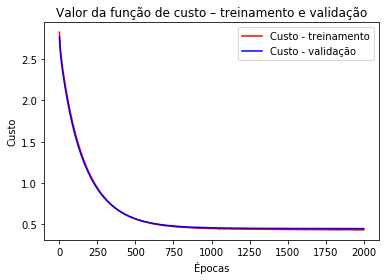

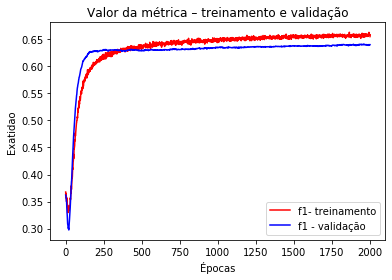

In [26]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [27]:
prob = np.ravel(model4.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.4401636661211129, 0.4921238870709992, 0.5354802552164166, 0.5774941770186336, 0.614133969217429, 0.6487334137515078, 0.6819372606972527, 0.7138037039814051, 0.7453284856683859, 0.7765855527878904, 0.8058124174372523, 0.834619341563786, 0.8610299769408147, 0.8843786071565987, 0.9165800415800416, 0.940935192780968, 0.9720410065237651, 0.98989898989899]
recall values: [0.9510573590777283, 0.9147747365443101, 0.8784921140108919, 0.8417144069594737, 0.8014711082820567, 0.7607327250866398, 0.7180140038192234, 0.6733149444798077, 0.6234528608812504, 0.5733078718438362, 0.5177169531084235, 0.45901407454558313, 0.3961383407596011, 0.3251290756064785, 0.24945187071221445, 0.16224626918452506, 0.07376759318197892, 0.006931183251998019]
f1 values: [0.6018035758240283, 0.6399643749536134, 0.6653810097763493, 0.6850087777362074, 0.6954067073732012, 0.7002832123441518, 0.6995107834355406, 0.6929684087931286, 0.6789648001232381, 0.6596411278837938, 0.6304095078155277, 0.5922883869

Normalized confusion matrix
[[0.45552655 0.54447345]
 [0.04894264 0.95105736]]
Normalized confusion matrix
[[0.57506685 0.42493315]
 [0.08522526 0.91477474]]
Normalized confusion matrix
[[0.65697822 0.34302178]
 [0.12150789 0.87849211]]
Normalized confusion matrix
[[0.72281294 0.27718706]
 [0.15828559 0.84171441]]
Normalized confusion matrix
[[0.77333503 0.22666497]
 [0.19852889 0.80147111]]
Normalized confusion matrix
[[0.81459315 0.18540685]
 [0.23926727 0.76073273]]
Normalized confusion matrix
[[0.84926143 0.15073857]
 [0.281986   0.718014  ]]
Normalized confusion matrix
[[0.87848593 0.12151407]
 [0.32668506 0.67331494]]
Normalized confusion matrix
[[0.90411308 0.09588692]
 [0.37654714 0.62345286]]
Normalized confusion matrix
[[0.92576086 0.07423914]
 [0.42669213 0.57330787]]
Normalized confusion matrix
[[0.94384312 0.05615688]
 [0.48228305 0.51771695]]
Normalized confusion matrix
[[0.95906023 0.04093977]
 [0.54098593 0.45901407]]
Normalized confusion matrix
[[0.97122119 0.02877881]

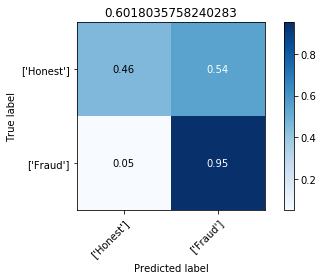

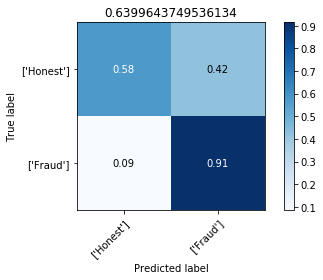

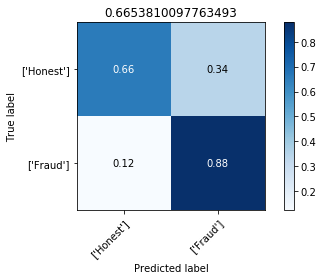

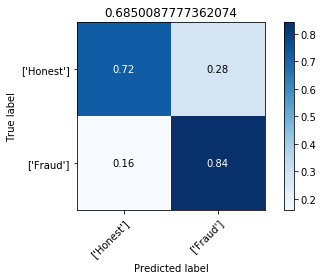

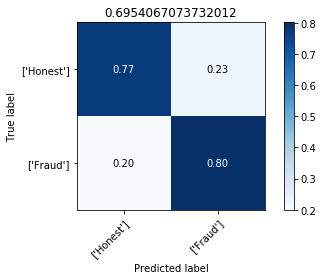

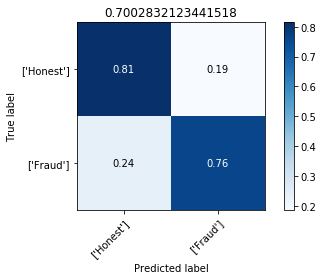

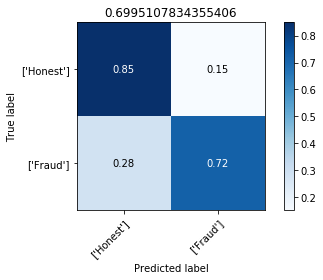

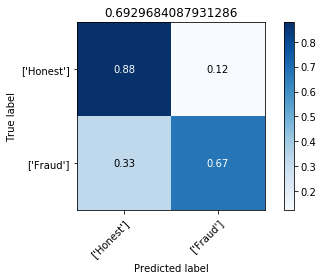

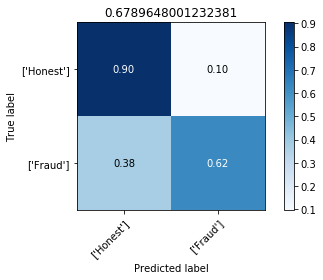

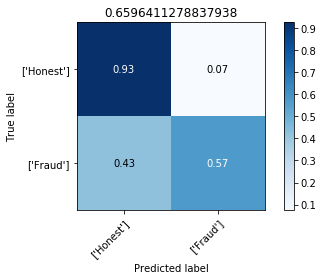

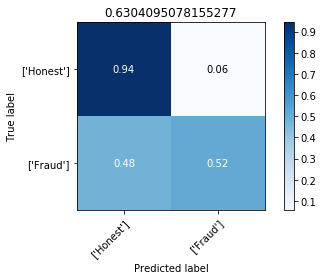

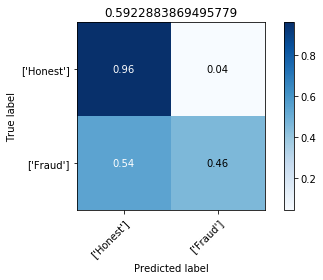

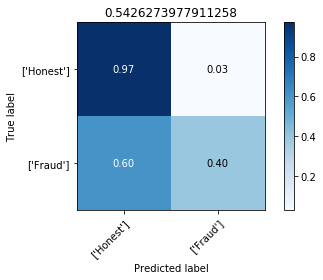

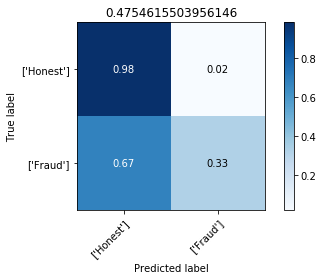

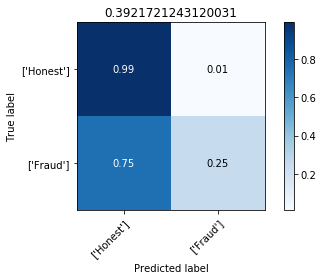

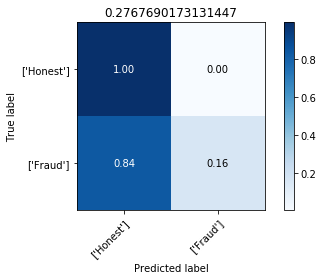

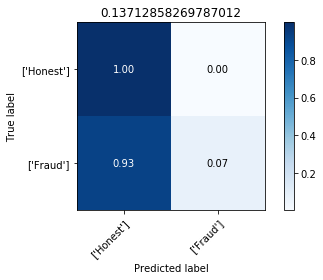

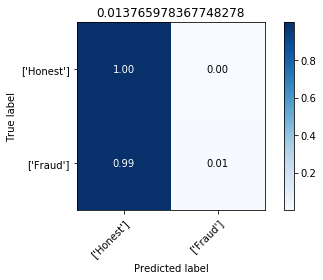

In [28]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)